In [2]:
# imports
import jax
jax.config.update("jax_default_device",jax.devices()[0])
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
from jax.random import PRNGKey as pkey
from jax.scipy.linalg import solve
# Other libraries
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLines
from matplotlib.lines import Line2D
from tqdm.auto import tqdm
# plt.style.use("ggplot")
from importlib import reload

# Our libraries
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import OperatorModel, OperatorPDEModel,CholInducedRKHS,InducedOperatorModel,SharedOperatorPDEModel
from plotting import plot_obs,plot_compare_error
from evaluation_metrics import get_nrmse,table_u_errors
from data_utils import (
    get_xy_grid_pairs,
    GP_sampler,
    build_xy_grid,
    sample_xy_grid_latin,
    build_input_observations,
    build_u_obs_single,
    build_u_obs_all,
    sample_multiple_xy_grids_latin
)

from Kernels import (
    get_gaussianRBF,
    get_centered_scaled_poly_kernel
)

import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers.solvers_base import *

from Optimizers import BlockArrowLM,LMParams, CholeskyLM

# Other libraries
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLines
from matplotlib.lines import Line2D
plt.style.use('default')
import matplotlib.ticker as ticker
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 20
})

In [3]:
# in_sample errors
err_is = jnp.load('../in_sample/errors.npy', allow_pickle=True).item()
# in_distribution errors
err_id = jnp.load('../in_distribution/errors.npy', allow_pickle=True).item()
# out_distribution errors
err_od = jnp.load('../out_distribution/errors.npy', allow_pickle=True).item()
# operator_learning errors
err_ol = jnp.load('../operator_learning/errors.npy', allow_pickle=True).item()

## Error curves

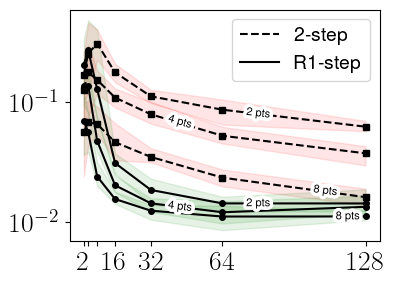

In [4]:
# in-sample errors plot
plt.figure(figsize=(4,3))
NUM_FUN_LIST = [2,4,8,16,32,64,128]
NUM_RUNS = 10
OBS_PTS_LIST = [2,4,8]
# plt.title('In sample error: u_new ~ GP(0,RBF(0.5))')
ms = NUM_FUN_LIST
# Colors
c2 = 'black'
c1 = 'black'
# 2-step method plot
for obs_pt in OBS_PTS_LIST:
    # 2 method
    mean_2 = jnp.array([jnp.mean(e) for e in jnp.array(err_is['2_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    # sd_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    upper_2 = jnp.array([jnp.nanmax(jnp.array(el)) for el in jnp.array(err_is['2_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    lower_2 = jnp.array([jnp.nanmin(jnp.array(el)) for el in jnp.array(err_is['2_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    # Plot 2 method
    plt.plot(ms, mean_2, label = f'{obs_pt} pts', marker= 's', linestyle = 'dashed',markersize = 4, color = c2)
    # plt.fill_between(ms, mean_2 - sd_2, mean_2 + sd_2, alpha=.1, color = 'red')
    plt.fill_between(ms, lower_2, upper_2, alpha=.1, color = 'red')
    plt.yscale('log')
    plt.minorticks_off()
# 1-step method plot
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err_is['1_5_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    # sd_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    upper_1_5 = jnp.array([jnp.nanmax(jnp.array(el)) for el in jnp.array(err_is['1_5_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    lower_1_5 = jnp.array([jnp.nanmin(jnp.array(el)) for el in jnp.array(err_is['1_5_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    # Plot 1_5 method
    plt.plot(ms, mean_1_5, label = f'{obs_pt} pts', marker= 'o',markersize = 4, color = c1)
    # plt.fill_between(ms, mean_1_5 - sd_1_5, mean_1_5 + sd_1_5, alpha=.1, color = 'green')
    plt.fill_between(ms, lower_1_5, upper_1_5, alpha=.1, color = 'green')
    plt.yscale('log')
    plt.minorticks_off()

# major_tick_labels = [r'$2$', r'$4$', r'$8$', r'$16$', r'$32$']
major_tick_labels = [r'$2$', r'', r'', r'$16$', r'$32$', r'$64$', r'$128$']
major_tick_positions = [2, 4, 8, 16, 32, 64,128]
plt.xticks(ticks = major_tick_positions, 
           labels = major_tick_labels, 
           minor=False
           )
# plt.ylim(top = 1e-0)
# plt.title(r'$\mathcal{R}_{\rm{eql}} \left((u^m)_{m=1}^M\right)$')
# plt.xlabel(r'$M$')
# adding labels to the plotlines
xvals_2step = [80,45,110]
xvals_1step = [80,45,120]
xvals = xvals_2step + xvals_1step
lines = plt.gca().get_lines()
labelLines(lines, align=True, xvals = xvals,fontsize=8)
# add legend box
legend_elements = [Line2D([0], [0], color= c2, linestyle = 'dashed', label='2-step'),
                   Line2D([0], [0], color= c1, label='R1-step')]
plt.legend(handles = legend_elements, loc = 'upper right', fontsize = 14)
plt.savefig('in_sample_errors2.pdf',
            format = 'pdf',
            dpi = 300,
            bbox_inches='tight')
plt.show()

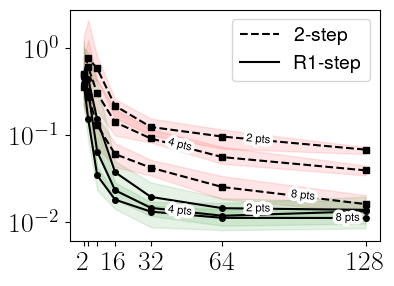

In [5]:
# in-distribution errors plot
plt.figure(figsize=(4,3))
NUM_FUN_LIST = [2,4,8,16,32,64,128]
NUM_RUNS = 10
OBS_PTS_LIST = [2,4,8]
# plt.title('In distribution error: u_new ~ GP(0,RBF(0.5))')
ms = NUM_FUN_LIST
# Colors
c2 = 'black'
c1 = 'black'

# 2-step method plot
for obs_pt in OBS_PTS_LIST:
    # 2 method
    mean_2 = jnp.array([jnp.mean(e) for e in jnp.array(err_id['2_mthd'][f'{obs_pt}_obs']['i_dis'])])
    # sd_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_dis'])])
    upper_2 = jnp.array([jnp.nanmax(jnp.array(el)) for el in jnp.array(err_id['2_mthd'][f'{obs_pt}_obs']['i_dis'])])
    lower_2 = jnp.array([jnp.nanmin(jnp.array(el)) for el in jnp.array(err_id['2_mthd'][f'{obs_pt}_obs']['i_dis'])])
    # Plot 2 method
    plt.plot(ms, mean_2, label = f'{obs_pt} pts', marker= 's',linestyle='dashed',markersize = 4, color = c2)
    # plt.fill_between(ms, mean_2 - sd_2, mean_2 + sd_2, alpha=.1, color = 'red')
    plt.fill_between(ms, lower_2, upper_2, alpha=.1, color = 'red')
    plt.yscale('log')
    plt.minorticks_off()
# 1-step method plot
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err_id['1_5_mthd'][f'{obs_pt}_obs']['i_dis'])])
    # sd_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_dis'])])
    upper_1_5 = jnp.array([jnp.nanmax(jnp.array(el)) for el in jnp.array(err_id['1_5_mthd'][f'{obs_pt}_obs']['i_dis'])])
    lower_1_5 = jnp.array([jnp.nanmin(jnp.array(el)) for el in jnp.array(err_id['1_5_mthd'][f'{obs_pt}_obs']['i_dis'])])
    # Plot 1_5 method
    plt.plot(ms, mean_1_5, label = f'{obs_pt} pts', marker= 'o',markersize = 4, color = c1)
    # plt.fill_between(ms, mean_1_5 - sd_1_5, mean_1_5 + sd_1_5, alpha=.1, color = 'green')
    plt.fill_between(ms, lower_1_5, upper_1_5, alpha=.1, color = 'green')
    plt.yscale('log')
    plt.minorticks_off()


# major_tick_labels = [r'$2$', r'$4$', r'$8$', r'$16$', r'$32$']
major_tick_labels = [r'$2$', r'', r'', r'$16$', r'$32$', r'$64$', r'$128$']
major_tick_positions = [2,4,8,16,32,64,128]

plt.xticks(ticks = major_tick_positions, 
           labels = major_tick_labels, 
           minor=False
           )
# plt.ylim(bottom = 1e-2)
# plt.title(r'$\mathcal{R}_{\rm{eql}} \left(\mathcal{W}_{\rm{ID}}\right)$')
# plt.xlabel(r'$M$')
# adding labels to the plotlines
xvals_2step = [80,45,100]
xvals_1step = [80,45,120]
xvals = xvals_2step + xvals_1step
lines = plt.gca().get_lines()
labelLines(lines, align=True, xvals = xvals,fontsize=8)
# add legend box
legend_elements = [Line2D([0], [0], color= c2, linestyle='dashed', label='2-step'),
                   Line2D([0], [0], color= c1, label='R1-step')]
plt.legend(handles = legend_elements, loc = 'upper right', fontsize=14)
plt.savefig('in_distribution_errors2.pdf',
            format = 'pdf',
            dpi = 300,
            bbox_inches='tight')
plt.show()

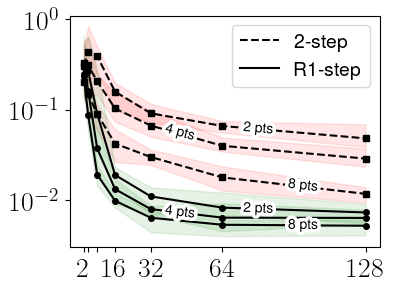

In [10]:
# out-distribution errors plot
plt.figure(figsize=(4,3))
NUM_FUN_LIST = [2,4,8,16,32,64,128]
NUM_RUNS = 10
OBS_PTS_LIST = [2,4,8]
# plt.title('Out of distribution error: u_new ~ GP(0,RBF(0.2))')
ms = NUM_FUN_LIST
# Colors
c2 = 'black'
c1 = 'black'
# 2-step method plot
for obs_pt in OBS_PTS_LIST:
    # 2 method
    mean_2 = jnp.array([jnp.mean(e) for e in jnp.array(err_od['2_mthd'][f'{obs_pt}_obs']['o_dis'])])
    # sd_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['o_dis'])])
    upper_2 = jnp.array([jnp.nanmax(jnp.array(el)) for el in jnp.array(err_od['2_mthd'][f'{obs_pt}_obs']['o_dis'])])
    lower_2 = jnp.array([jnp.nanmin(jnp.array(el)) for el in jnp.array(err_od['2_mthd'][f'{obs_pt}_obs']['o_dis'])])
    # Plot 2 method
    plt.plot(ms, mean_2, label = f'{obs_pt} pts', marker= 's', linestyle = 'dashed',markersize = 4,color = c2)
    # plt.fill_between(ms, mean_2 - sd_2, mean_2 + sd_2, alpha=.1, color = 'red')
    plt.fill_between(ms, lower_2, upper_2, alpha=.1, color = 'red')
    plt.yscale('log')
    plt.minorticks_off()
# 1-step method plot
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err_od['1_5_mthd'][f'{obs_pt}_obs']['o_dis'])])
    # sd_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['o_dis'])])
    upper_1_5 = jnp.array([jnp.nanmax(jnp.array(el)) for el in jnp.array(err_od['1_5_mthd'][f'{obs_pt}_obs']['o_dis'])])
    lower_1_5 = jnp.array([jnp.nanmin(jnp.array(el)) for el in jnp.array(err_od['1_5_mthd'][f'{obs_pt}_obs']['o_dis'])])
    # Plot 1_5 method
    plt.plot(ms, mean_1_5, label = f'{obs_pt} pts', marker= 'o',markersize = 4, color = c1)
    # plt.fill_between(ms, mean_1_5 - sd_1_5, mean_1_5 + sd_1_5, alpha=.1, color = 'green')
    plt.fill_between(ms, lower_1_5, upper_1_5, alpha=.1, color = 'green')
    plt.yscale('log')
    plt.minorticks_off()

major_tick_labels = [r'$2$', r'', r'', r'$16$', r'$32$', r'$64$', r'$128$']
major_tick_positions = [2,4,8,16,32,64,128]
plt.xticks(ticks = major_tick_positions, 
           labels = major_tick_labels, 
           minor=False
           )
# plt.ylim(bottom = 1e-2)
# plt.title(r'$\mathcal{R}_{\rm{eql}} \left(\mathcal{W}_{\rm{OOD}}\right)$')
# plt.xlabel(r'$M$')
# adding labels to the plotlines
xvals_2step = [80,45,100]
xvals_1step = [80,45,100]
xvals = xvals_2step + xvals_1step
lines = plt.gca().get_lines()
labelLines(lines, align=True, xvals = xvals,fontsize=10)
# add legend box
legend_elements = [Line2D([0], [0], color= c2, linestyle='dashed',label='2-step'),
                   Line2D([0], [0], color= c1, label='R1-step')]
plt.legend(handles = legend_elements, loc = 'upper right',fontsize=14)
plt.savefig('out_distribution_errors2.pdf',
            format = 'pdf',
            dpi = 300,
            bbox_inches='tight')
plt.show()

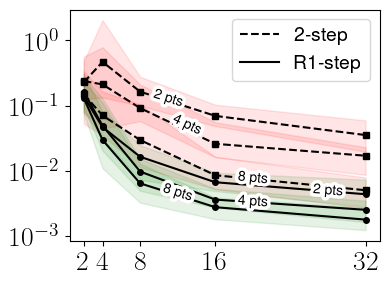

In [6]:
# operator_learning errors plot
plt.figure(figsize=(4,3))
NUM_FUN_LIST = [2,4,8,16,32]
NUM_RUNS = 10
OBS_PTS_LIST = [2,4,8]
# plt.title('Operator learning error: u_new ~ GP(0,RBF(0.5))')
ms = NUM_FUN_LIST
# Colors
c1 = 'black'
c2 = 'black'
# 2-step method plot
for obs_pt in OBS_PTS_LIST:
    # 2 method
    mean_2 = jnp.array([jnp.mean(e) for e in jnp.array(err_ol['2_mthd'][f'{obs_pt}_obs']['i_opt'])])
    # sd_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_opt'])])
    upper_2 = jnp.array([jnp.nanmax(jnp.array(el)) for el in jnp.array(err_ol['2_mthd'][f'{obs_pt}_obs']['i_opt'])])
    lower_2 = jnp.array([jnp.nanmin(jnp.array(el)) for el in jnp.array(err_ol['2_mthd'][f'{obs_pt}_obs']['i_opt'])])
    # Plot 2 method
    plt.plot(ms, mean_2, label = f'{obs_pt} pts', marker= 's', linestyle = 'dashed',markersize = 4, color = c2)
    # plt.fill_between(ms, mean_2 - sd_2, mean_i_opt_2 + sd_i_opt_2, alpha=.1, color = 'red')
    plt.fill_between(ms, lower_2, upper_2, alpha=.1, color = 'red')
    plt.yscale('log')
    plt.minorticks_off()
# 1-step method plot
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err_ol['1_5_mthd'][f'{obs_pt}_obs']['i_opt'])])
    # sd_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_opt'])])
    upper_1_5 = jnp.array([jnp.nanmax(jnp.array(el)) for el in jnp.array(err_ol['1_5_mthd'][f'{obs_pt}_obs']['i_opt'])])
    lower_1_5 = jnp.array([jnp.nanmin(jnp.array(el)) for el in jnp.array(err_ol['1_5_mthd'][f'{obs_pt}_obs']['i_opt'])])
    # Plot 1_5 method
    plt.plot(ms, mean_1_5, label = f'{obs_pt} pts', marker= 'o',markersize = 4, color = c1)
    # plt.fill_between(ms, mean_1_5 - sd_1_5, mean_i_opt_1_5 + sd_i_opt_1_5, alpha=.1, color = 'green')
    plt.fill_between(ms, lower_1_5, upper_1_5, alpha=.1, color = 'green')
    plt.yscale('log')
    plt.minorticks_off()

major_tick_labels = [r'$2$', r'$4$', r'$8$', r'$16$', r'$32$']
major_tick_positions = [2, 4, 8, 16, 32]
plt.xticks(ticks = major_tick_positions, 
           labels = major_tick_labels, 
           minor=False
           )
# plt.ylim(top = 1e-0)
# plt.title(r'$\mathcal{R}_{\rm{opl}} \left(\mathcal{W}_{\rm{ID}}\right)$')
# plt.xlabel(r'$M$')


# adding labels to the plotlines
xvals_2step = [11,13,20]
xvals_1step = [28,20,12]
xvals = xvals_2step + xvals_1step
lines = plt.gca().get_lines()
labelLines(lines, align=True, xvals = xvals, fontsize = 10)
# add legend box
legend_elements = [Line2D([0], [0], color= c2, linestyle='dashed', label='2-step'),
                   Line2D([0], [0], color= c1, label='R1-step')]
plt.legend(handles = legend_elements, loc = 'upper right',fontsize=14)
plt.savefig('operator_learning_errors.pdf',
            format = 'pdf',
            dpi = 300,
            bbox_inches='tight')
plt.show()

## u's and f's: n = 2obs

In [17]:
# generate u's and f's
m = 5
obs_pts = 2
run = 0
seed = int(m*obs_pts*(run+1))

# Sample m functions
kernel_GP = get_gaussianRBF(0.5)
xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
u_true_functions = tuple(GP_sampler(num_samples = m,
                                        X = xy_pairs, 
                                        kernel = kernel_GP,
                                        reg = 1e-12,
                                        seed = seed
                                    )
                                    )
# fine grid
xy_fine = jnp.vstack(build_xy_grid([0,1],[0,1],100,100))

# Permeability field A
def A(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

# Compute f = Pu for a given u
def get_rhs_darcy(u):
    def Agradu(xy):
        return A(xy)*jax.grad(u)(xy)
    def Pu(xy):
        return jnp.trace(jax.jacfwd(Agradu)(xy))
    return Pu
# Sample collocation points for f using same uniform grid for every function
xy_int_single,xy_bdy_single = build_xy_grid([0,1],[0,1],10,10)
xy_ints = (xy_int_single,)*m
xy_bdys = (xy_bdy_single,)*m


xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

# List of number of observation points per u
num_obs = [obs_pts]*m

# u's
u_s = tuple([jax.vmap(u) for u in u_true_functions])
u_trues_is = [u(xy_fine) for u in u_s]
# f
f_s = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions])
f_trues_is = [f(xy_fine) for f in f_s]

# Get (X^m, u^m(X^m))
xy_obs,u_obs = build_u_obs_all(
    num_obs,
    xy_ints,
    xy_bdys,
    u_s,
    pkey(seed)
)

In [18]:
# vmin and vmax to use same colors
u_s_stacked = jnp.stack(u_trues_is)
vmin_u_s, vmax_u_s = jnp.min(u_s_stacked), jnp.max(u_s_stacked)

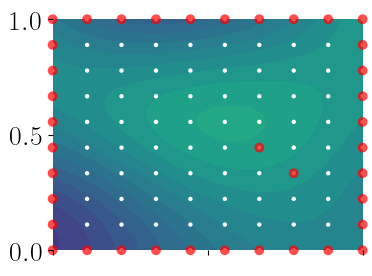

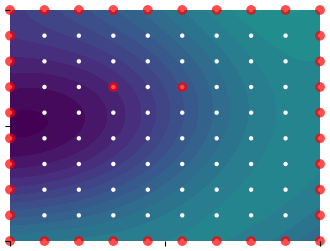

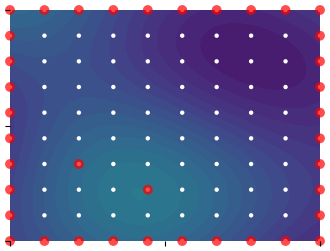

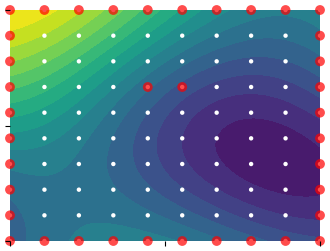

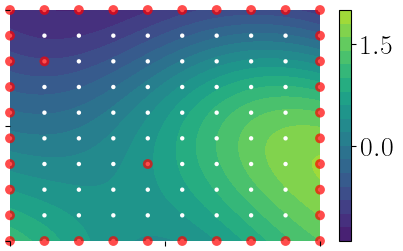

In [19]:
# u_true_is
for i in range(5):
    if i!= 4:
        plt.figure(figsize=(4,3))
    else:
        plt.figure(figsize=(5,3))
    cp = plt.tricontourf(*xy_fine.T, u_trues_is[i],
                    levels=15, 
                    vmin=vmin_u_s, 
                    vmax=vmax_u_s)
    # coll grid
    plt.scatter(*(xy_all[i]).T,
                c='white',
                s = 10,
                clip_on =False, 
                edgecolors = 'none')
    # obs grid
    plt.scatter(*(xy_obs[i]).T,
                c='red', 
                s = 50, 
                alpha = 0.7,
                clip_on =False,
                edgecolors = 'none')
    
    # fig settings
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.locator_params(nbins=3)
    plt.gca().set_xticklabels([])
    
    # only left-most needs y tick labels
    if i != 0:
        plt.gca().set_yticklabels([])

    # only righ-most needs colorbar   
    if i == 4:  
        cb = plt.colorbar(cp)
        tick_locator = ticker.MaxNLocator(nbins=3)
        cb.locator = tick_locator
        cb.update_ticks()

    # save fig
    plt.savefig(f'darcy_u2_is{i+1}.pdf',
                dpi=300,
                bbox_inches='tight',
                format ="pdf"
                )

In [20]:
# vmin and vmax to use same colors
f_s_stacked = jnp.stack(f_trues_is)
vmin_f_s, vmax_f_s = jnp.min(f_s_stacked), jnp.max(f_s_stacked)

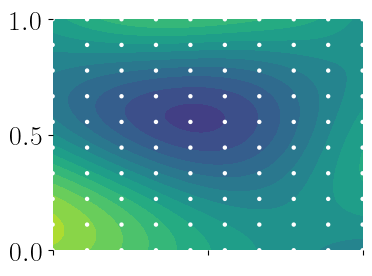

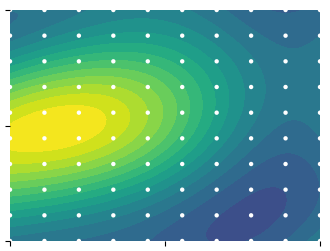

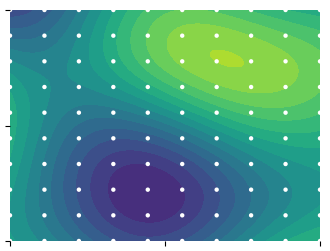

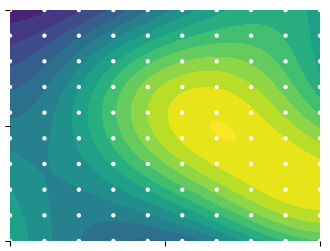

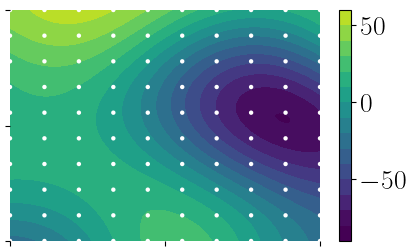

In [21]:
# f_true_is
for i in range(5):
    if i!= 4:
        plt.figure(figsize=(4,3))
    else:
        plt.figure(figsize=(5,3))
    cp = plt.tricontourf(*xy_fine.T, f_trues_is[i],
                    levels=15, 
                    vmin=vmin_f_s, 
                    vmax=vmax_f_s)
    
    # coll grid
    plt.scatter(*(xy_all[i]).T,
                c='white',
                s = 10,
                clip_on =False, 
                edgecolors = 'none')
    
    # fig settings
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.locator_params(nbins=3)
    plt.gca().set_xticklabels([])
    
    # only left-most needs y tick labels
    if i != 0:
        plt.gca().set_yticklabels([])

    # only righ-most needs colorbar   
    if i == 4:  
        cb = plt.colorbar(cp)
        tick_locator = ticker.MaxNLocator(nbins=3)
        cb.locator = tick_locator
        cb.update_ticks()

    # save fig
    plt.savefig(f'darcy_f2_is{i+1}.pdf',
                dpi=300,
                bbox_inches='tight',
                format ="pdf"
                )

## u's and f's: n = 4obs

In [22]:
# generate u's and f's
m = 5
obs_pts = 4
run = 0
seed = int(m*obs_pts*(run+1))

# Sample m functions
kernel_GP = get_gaussianRBF(0.5)
xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
u_true_functions = tuple(GP_sampler(num_samples = m,
                                        X = xy_pairs, 
                                        kernel = kernel_GP,
                                        reg = 1e-12,
                                        seed = seed
                                    )
                                    )
# fine grid
xy_fine = jnp.vstack(build_xy_grid([0,1],[0,1],100,100))

# Permeability field A
def A(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

# Compute f = Pu for a given u
def get_rhs_darcy(u):
    def Agradu(xy):
        return A(xy)*jax.grad(u)(xy)
    def Pu(xy):
        return jnp.trace(jax.jacfwd(Agradu)(xy))
    return Pu
# Sample collocation points for f using same uniform grid for every function
xy_int_single,xy_bdy_single = build_xy_grid([0,1],[0,1],10,10)
xy_ints = (xy_int_single,)*m
xy_bdys = (xy_bdy_single,)*m


xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

# List of number of observation points per u
num_obs = [obs_pts]*m

# u's
u_s = tuple([jax.vmap(u) for u in u_true_functions])
u_trues_is = [u(xy_fine) for u in u_s]
# f
f_s = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions])
f_trues_is = [f(xy_fine) for f in f_s]

# Get (X^m, u^m(X^m))
xy_obs,u_obs = build_u_obs_all(
    num_obs,
    xy_ints,
    xy_bdys,
    u_s,
    pkey(seed)
)

In [23]:
# vmin and vmax to use same colors
u_s_stacked = jnp.stack(u_trues_is)
vmin_u_s, vmax_u_s = jnp.min(u_s_stacked), jnp.max(u_s_stacked)

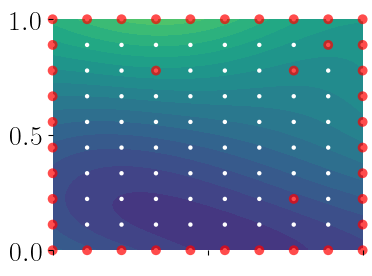

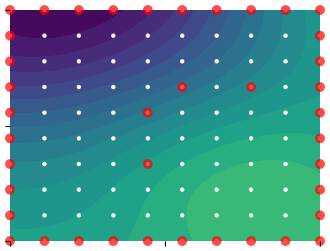

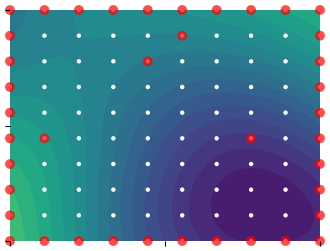

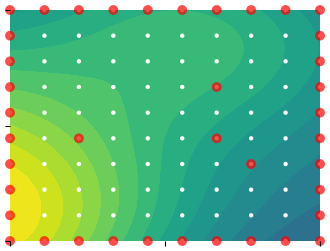

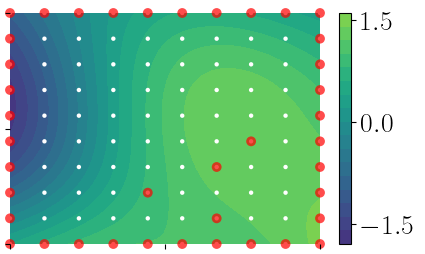

In [24]:
# u_true_is
for i in range(5):
    if i!= 4:
        plt.figure(figsize=(4,3))
    else:
        plt.figure(figsize=(5,3))
    cp = plt.tricontourf(*xy_fine.T, u_trues_is[i],
                    levels=15, 
                    vmin=vmin_u_s, 
                    vmax=vmax_u_s)
    # coll grid
    plt.scatter(*(xy_all[i]).T,
                c='white',
                s = 10,
                clip_on =False, 
                edgecolors = 'none')
    # obs grid
    plt.scatter(*(xy_obs[i]).T,
                c='red', 
                s = 50, 
                alpha = 0.7,
                clip_on =False,
                edgecolors = 'none')
    
    # fig settings
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.locator_params(nbins=3)
    plt.gca().set_xticklabels([])
    
    # only left-most needs y tick labels
    if i != 0:
        plt.gca().set_yticklabels([])

    # only righ-most needs colorbar   
    if i == 4:  
        cb = plt.colorbar(cp)
        tick_locator = ticker.MaxNLocator(nbins=3)
        cb.locator = tick_locator
        cb.update_ticks()

    # save fig
    plt.savefig(f'darcy_u4_is{i+1}.pdf',
                dpi=300,
                bbox_inches='tight',
                format ="pdf"
                )

In [25]:
# vmin and vmax to use same colors
f_s_stacked = jnp.stack(f_trues_is)
vmin_f_s, vmax_f_s = jnp.min(f_s_stacked), jnp.max(f_s_stacked)

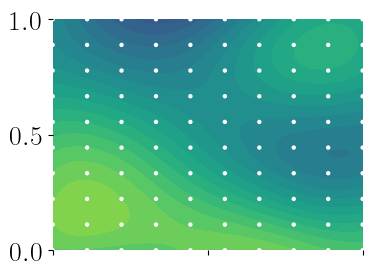

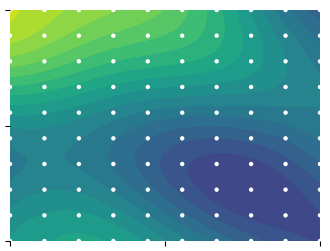

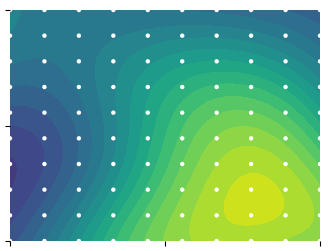

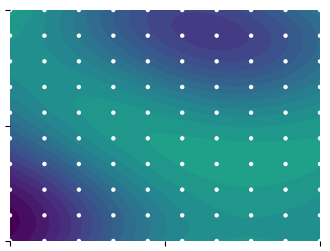

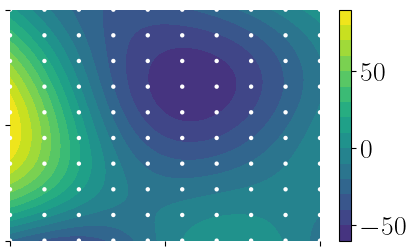

In [26]:
# f_true_is
for i in range(5):
    if i!= 4:
        plt.figure(figsize=(4,3))
    else:
        plt.figure(figsize=(5,3))
    cp = plt.tricontourf(*xy_fine.T, f_trues_is[i],
                    levels=15, 
                    vmin=vmin_f_s, 
                    vmax=vmax_f_s)
    
    # coll grid
    plt.scatter(*(xy_all[i]).T,
                c='white',
                s = 10,
                clip_on =False, 
                edgecolors = 'none')
    
    # fig settings
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.locator_params(nbins=3)
    plt.gca().set_xticklabels([])
    
    # only left-most needs y tick labels
    if i != 0:
        plt.gca().set_yticklabels([])

    # only righ-most needs colorbar   
    if i == 4:  
        cb = plt.colorbar(cp)
        tick_locator = ticker.MaxNLocator(nbins=3)
        cb.locator = tick_locator
        cb.update_ticks()

    # save fig
    plt.savefig(f'darcy_f4_is{i+1}.pdf',
                dpi=300,
                bbox_inches='tight',
                format ="pdf"
                )

## u's and f's: n = 8obs

In [27]:
# generate u's and f's
m = 5
obs_pts = 8
run = 0
seed = int(m*obs_pts*(run+1))

# Sample m functions
kernel_GP = get_gaussianRBF(0.5)
xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
u_true_functions = tuple(GP_sampler(num_samples = m,
                                        X = xy_pairs, 
                                        kernel = kernel_GP,
                                        reg = 1e-12,
                                        seed = seed
                                    )
                                    )
# fine grid
xy_fine = jnp.vstack(build_xy_grid([0,1],[0,1],100,100))

# Permeability field A
def A(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

# Compute f = Pu for a given u
def get_rhs_darcy(u):
    def Agradu(xy):
        return A(xy)*jax.grad(u)(xy)
    def Pu(xy):
        return jnp.trace(jax.jacfwd(Agradu)(xy))
    return Pu
# Sample collocation points for f using same uniform grid for every function
xy_int_single,xy_bdy_single = build_xy_grid([0,1],[0,1],10,10)
xy_ints = (xy_int_single,)*m
xy_bdys = (xy_bdy_single,)*m


xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

# List of number of observation points per u
num_obs = [obs_pts]*m

# u's
u_s = tuple([jax.vmap(u) for u in u_true_functions])
u_trues_is = [u(xy_fine) for u in u_s]
# f
f_s = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions])
f_trues_is = [f(xy_fine) for f in f_s]

# Get (X^m, u^m(X^m))
xy_obs,u_obs = build_u_obs_all(
    num_obs,
    xy_ints,
    xy_bdys,
    u_s,
    pkey(seed)
)

In [28]:
# vmin and vmax to use same colors
u_s_stacked = jnp.stack(u_trues_is)
vmin_u_s, vmax_u_s = jnp.min(u_s_stacked), jnp.max(u_s_stacked)

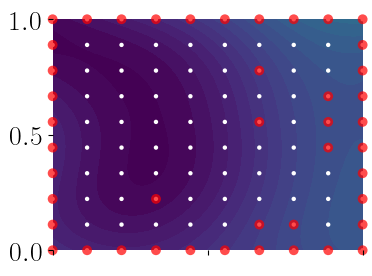

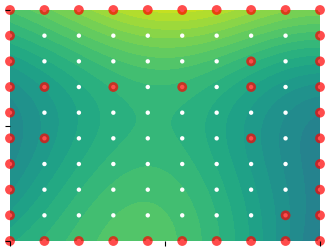

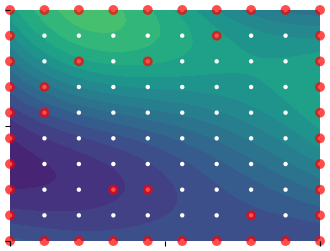

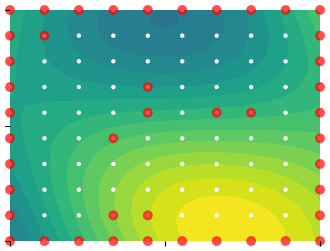

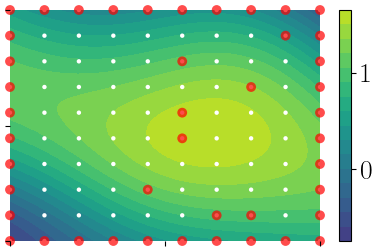

In [29]:
# u_true_is
for i in range(5):
    if i!= 4:
        plt.figure(figsize=(4,3))
    else:
        plt.figure(figsize=(5,3))
    cp = plt.tricontourf(*xy_fine.T, u_trues_is[i],
                    levels=15, 
                    vmin=vmin_u_s, 
                    vmax=vmax_u_s)
    # coll grid
    plt.scatter(*(xy_all[i]).T,
                c='white',
                s = 10,
                clip_on =False, 
                edgecolors = 'none')
    # obs grid
    plt.scatter(*(xy_obs[i]).T,
                c='red', 
                s = 50, 
                alpha = 0.7,
                clip_on =False,
                edgecolors = 'none')
    
    # fig settings
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.locator_params(nbins=3)
    plt.gca().set_xticklabels([])
    
    # only left-most needs y tick labels
    if i != 0:
        plt.gca().set_yticklabels([])

    # only righ-most needs colorbar   
    if i == 4:  
        cb = plt.colorbar(cp)
        tick_locator = ticker.MaxNLocator(nbins=3)
        cb.locator = tick_locator
        cb.update_ticks()

    # save fig
    plt.savefig(f'darcy_u8_is{i+1}.pdf',
                dpi=300,
                bbox_inches='tight',
                format ="pdf"
                )

In [30]:
# vmin and vmax to use same colors
f_s_stacked = jnp.stack(f_trues_is)
vmin_f_s, vmax_f_s = jnp.min(f_s_stacked), jnp.max(f_s_stacked)

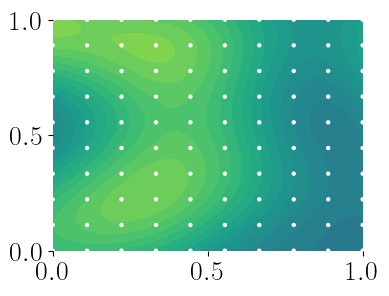

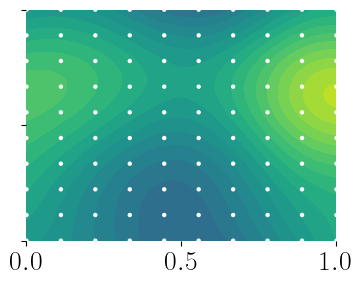

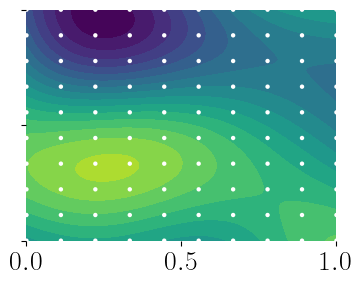

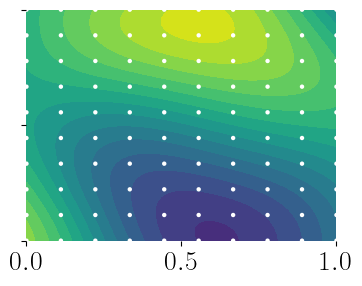

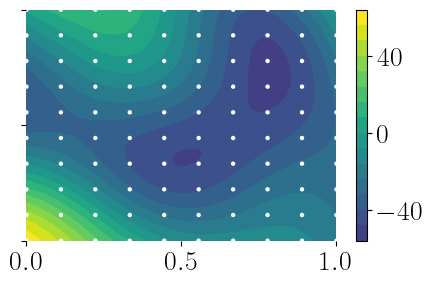

In [31]:
# f_true_is
for i in range(5):
    if i!= 4:
        plt.figure(figsize=(4,3))
    else:
        plt.figure(figsize=(5,3))
    cp = plt.tricontourf(*xy_fine.T, f_trues_is[i],
                    levels=15, 
                    vmin=vmin_f_s, 
                    vmax=vmax_f_s)
    
    # coll grid
    plt.scatter(*(xy_all[i]).T,
                c='white',
                s = 10,
                clip_on =False, 
                edgecolors = 'none')
    
    # fig settings
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.locator_params(nbins=3)
    # plt.gca().set_xticklabels([])
    
    # only left-most needs y tick labels
    if i != 0:
        plt.gca().set_yticklabels([])

    # only righ-most needs colorbar   
    if i == 4:  
        cb = plt.colorbar(cp)
        tick_locator = ticker.MaxNLocator(nbins=3)
        cb.locator = tick_locator
        cb.update_ticks()

    # save fig
    plt.savefig(f'darcy_f8_is{i+1}.pdf',
                dpi=300,
                bbox_inches='tight',
                format ="pdf"
                )

## errors in-distribution(ID): run = 0

In [66]:
# errors for ID - 1 step
m = 8
obs_pts = 8
run = 0
seed = int(m*obs_pts*(run+1))

# Sample m functions
kernel_GP = get_gaussianRBF(0.5)
xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
u_true_functions = tuple(GP_sampler(num_samples = m,
                                        X = xy_pairs, 
                                        kernel = kernel_GP,
                                        reg = 1e-12,
                                        seed = seed
                                    )
                                    )
# fine grid
xy_fine = jnp.vstack(build_xy_grid([0,1],[0,1],100,100))

# Permeability field A
def A(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

# Compute f = Pu for a given u
def get_rhs_darcy(u):
    def Agradu(xy):
        return A(xy)*jax.grad(u)(xy)
    def Pu(xy):
        return jnp.trace(jax.jacfwd(Agradu)(xy))
    return Pu

# Lists of m true u's and f's
vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed


# Sample collocation points for f using same uniform grid for every function
xy_int_single,xy_bdy_single = build_xy_grid([0,1],[0,1],10,10)
xy_ints = (xy_int_single,)*m
xy_bdys = (xy_bdy_single,)*m


xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

# List of number of observation points per u
num_obs = [obs_pts]*m

# Get (X^m, u^m(X^m))
xy_obs,u_obs = build_u_obs_all(
    num_obs,
    xy_ints,
    xy_bdys,
    vmapped_u_true_functions,
    pkey(seed)
)

# Build operator features
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

# Build interpolants for u's
k_u = get_gaussianRBF(0.5)
u_operators = (eval_k,)

# u_models = tuple([CholInducedRKHS(
#     xy_all[i],
#     u_operators,
#     k_u
#     ) for i in range(m)])

u_model = CholInducedRKHS(xy_all[0],u_operators,k_u)

# Get necessary tuples
observation_points = tuple(xy_obs)
observation_values = tuple(u_obs)
collocation_points = xy_ints


rhs_values = tuple(rhs_func(xy_int) for xy_int,rhs_func in zip(xy_ints,rhs_functions))

all_u_params_init = tuple([
    u_model.get_fitted_params(obs_loc,obs_val,lam = 1e-8)
    for obs_loc,obs_val in zip(observation_points,observation_values)])

grid_features_u_init = jnp.vstack([(
    u_model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for xy_int,model_params in zip(xy_ints,all_u_params_init) ])

grid_features_u_init = jnp.hstack([jnp.vstack(xy_ints),grid_features_u_init])

# P kernel
k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
k_P_x_part = get_gaussianRBF(0.4)

def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
    

# P object        
P_model = InducedOperatorModel(grid_features_u_init,k_P)
num_P_params = len(grid_features_u_init) 

# P, u, f object
collocation_points = xy_ints
EqnModel  = SharedOperatorPDEModel(
    P_model,
    u_model,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 5.,
    num_P_operator_params = 200
)

# OPTIMIZE

u_init = jnp.stack(all_u_params_init)
P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values),lam = 1e-4)

beta_reg = 1e-8

from Optimizers import BlockArrowLM,LMParams
lm_params = LMParams(max_iter = 501,init_alpha = 1e-1,min_alpha = 1e-12,print_every = 100)
u_sol,P_sol,arrow_conv = BlockArrowLM(
    u_init,P_init,EqnModel,beta_reg,beta_reg,
    optParams=lm_params
    )

# loss history
loss_vals_ID_BlockArrowLM = arrow_conv.loss_vals


# Simulate u true ID
kernel_GP_ID = get_gaussianRBF(0.5) # Same regularity as training u's
# Sample M training functions from GP(0,K)
u_true_ID = GP_sampler(num_samples = 1,
                X = xy_pairs, 
                kernel = kernel_GP_ID,
                reg = 1e-12,
                seed = seed
)
# P(u_ID)(xy_fine)
P_true_ID = jax.vmap(get_rhs_darcy(u_true_ID[0]))(xy_fine)
# Phat[S] - 1 step    
P_func = lambda x: P_model.predict(x,P_sol)
# P[\phi(w)](fine_grid)
def evaluate_hatP(P_func, w, fine_grid, feature_operators):
    # Build S_test
    w_features = jnp.array([jax.vmap(operator(w,0))(xy_fine) for operator in feature_operators]).T
    model_fine_features = jnp.hstack([fine_grid, w_features])
    S_test = model_fine_features
    P_preds = P_func(S_test)
    return P_preds
# P_hat(u_ID)(xy_fine)
P_pred_ID = evaluate_hatP(P_func, 
                           u_true_ID[0],
                           xy_fine,
                           feature_operators)

# Collocation points where to solve for \hat P (u) = f_new
num_interior_points = 256
num_grid_points = 20
# Sample collocation points for learning u
xy_interiors,xy_boundarys = sample_multiple_xy_grids_latin(
        num_functions = 1,
        num_interior = num_interior_points,
        x_range = [0,1],
        y_range = [0,1],
        num_grid_x_bdy = num_grid_points,
        num_grid_y_bdy = num_grid_points,
        key = pkey(0)
    )
# Boundary pairs
xy_bdy = xy_boundarys[0]
# Interior pairs (where PDE is satisfied)
xy_int = xy_interiors[0]
# Union of xy_bdy
xy_all = jnp.vstack([xy_int,xy_bdy])

# u_new object
u_model = CholInducedRKHS(
    xy_all,
    feature_operators,
    k_u
    )

def get_u_pde_adj(u_new,f_new):
        
    @jit
    def get_pred_hatP(input_features):
        return P_model.predict(input_features,P_sol)

    

    new_obs = u_new(xy_bdy) # Boundary conditions values that need to be satisfied


    class PdeModel():

        datafit_weight = 50.

        @jit
        def get_grid_features(u_params):
            evaluation = u_model.evaluate_operators(feature_operators,xy_int,u_params)
            grid_features = evaluation.reshape(len(xy_int),len(feature_operators),order = 'F')
            return jnp.hstack([xy_int,grid_features])
        
        @jit
        def get_grid_target(u_params):
            return f_new(xy_int)
        
        @jit
        def eval_obs_points(u_params):
            return u_model.point_evaluate(xy_bdy,u_params)
        
        @jit
        def datafit_residual(u_params):
            obs_preds = PdeModel.eval_obs_points(u_params)
            return new_obs - obs_preds
        
        @jit
        def equation_residual(u_params):
            P_features = PdeModel.get_grid_features(u_params)
            P_model_preds = get_pred_hatP(P_features)
            ugrid_target = PdeModel.get_grid_target(u_params)
            return (ugrid_target - P_model_preds)
        
        @jit
        def F(u_params):
            eqn_res = PdeModel.equation_residual(u_params)
            data_res = PdeModel.datafit_residual(u_params)
            return jnp.hstack([
                PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                eqn_res/jnp.sqrt(len(eqn_res))
                ])
        
        jac = jit(jacrev(F))

        def loss(u_params):
            return jnp.linalg.norm(PdeModel.F(u_params))**2
        
        @jit
        def damping_matrix(u_params):
            return u_model.kmat+1e-5 * diagpart(u_model.kmat)
    
    # Optimize
    new_u_init = jnp.zeros(xy_all.shape[0]*len(feature_operators))

    # Optimizer hyperparameters
    optparams = LMParams(max_iter = 301,
                        line_search_increase_ratio = 1.4,
                        print_every = 100,
                        tol = 1e-10)
    
    u_params_pde, _ = CholeskyLM(
        new_u_init.copy(),
        PdeModel,
        beta = 0,
        optParams = optparams
    )


    return u_params_pde
u_true_func = jax.vmap(u_true_ID[0])
f_true_func = jax.vmap(get_rhs_darcy(u_true_ID[0]))
u_pred_ol = u_model.point_evaluate(xy_fine,
                                   get_u_pde_adj(u_true_func,f_true_func)
)
# u_true_ID vals at fine grid
darcy_u_true_ID = jax.vmap(u_true_ID[0])(xy_fine)
# relative error values: P(u_true_ID) vs. Phat(u_true_ID)
darcy_P_fwd_error_ID_1step = jnp.abs(P_true_ID - P_pred_ID)/jnp.linalg.norm(P_true_ID)
# relative error values: u_true_ID vs. Phat^-1(P(u_true_ID))
darcy_P_bwd_error_ID_1step = jnp.abs(darcy_u_true_ID - u_pred_ol)/jnp.linalg.norm(darcy_u_true_ID)

  4%|▍         | 20/501 [00:03<01:00,  7.91it/s]

Iteration 0, loss = 0.07943, gradnorm = 1.661, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.06068, gradnorm = 0.06759, alpha = 0.06944, improvement_ratio = 1.001
Iteration 2, loss = 0.05061, gradnorm = 0.0347, alpha = 0.05787, improvement_ratio = 1.001
Iteration 3, loss = 0.04423, gradnorm = 0.0243, alpha = 0.04823, improvement_ratio = 1.001
Iteration 4, loss = 0.03999, gradnorm = 0.01778, alpha = 0.04019, improvement_ratio = 1.0
Iteration 5, loss = 0.03697, gradnorm = 0.01335, alpha = 0.03349, improvement_ratio = 1.0


 20%|██        | 102/501 [00:03<00:15, 25.71it/s]


Iteration 100, loss = 2.297e-05, gradnorm = 6.711e-08, alpha = 1.739e-09, improvement_ratio = 1.354


  3%|▎         | 10/301 [00:24<08:42,  1.79s/it] 

Iteration 0, loss = 0.0008453, gradnorm = 1.241e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 0.0005279, gradnorm = 0.0004238, alpha = 2.083, improvement_ratio = 1.0
Iteration 2, loss = 0.0004138, gradnorm = 0.0001629, alpha = 1.736, improvement_ratio = 1.0
Iteration 3, loss = 0.0003497, gradnorm = 0.0001109, alpha = 1.447, improvement_ratio = 1.0
Iteration 4, loss = 0.0003109, gradnorm = 8.163e-05, alpha = 1.206, improvement_ratio = 1.0
Iteration 5, loss = 0.0002871, gradnorm = 6.11e-05, alpha = 1.005, improvement_ratio = 1.0


 36%|███▌      | 109/301 [00:26<00:04, 42.35it/s]

Iteration 100, loss = 5.368e-06, gradnorm = 3.112e-07, alpha = 3.019e-08, improvement_ratio = 1.0


 72%|███████▏  | 217/301 [00:27<00:01, 81.89it/s]

Iteration 200, loss = 4.486e-06, gradnorm = 9.309e-07, alpha = 8.333e-09, improvement_ratio = 0.999


100%|██████████| 301/301 [00:28<00:00, 10.62it/s]


Iteration 300, loss = 4.182e-06, gradnorm = 4.07e-06, alpha = 8.333e-09, improvement_ratio = 1.004


In [67]:
# errors for ID - 2 step
m = 8
obs_pts = 8
run = 0
seed = int(m*obs_pts*(run+1))

# Sample m functions
kernel_GP = get_gaussianRBF(0.5)
xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
u_true_functions = tuple(GP_sampler(num_samples = m,
                                        X = xy_pairs, 
                                        kernel = kernel_GP,
                                        reg = 1e-12,
                                        seed = seed
                                    )
                                    )
# fine grid
xy_fine = jnp.vstack(build_xy_grid([0,1],[0,1],100,100))

# Permeability field A
def A(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

# Compute f = Pu for a given u
def get_rhs_darcy(u):
    def Agradu(xy):
        return A(xy)*jax.grad(u)(xy)
    def Pu(xy):
        return jnp.trace(jax.jacfwd(Agradu)(xy))
    return Pu

# Lists of m true u's and f's
vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed


# Sample collocation points for f using same uniform grid for every function
xy_int_single,xy_bdy_single = build_xy_grid([0,1],[0,1],10,10)
xy_ints = (xy_int_single,)*m
xy_bdys = (xy_bdy_single,)*m


xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

# List of number of observation points per u
num_obs = [obs_pts]*m

# Get (X^m, u^m(X^m))
xy_obs,u_obs = build_u_obs_all(
    num_obs,
    xy_ints,
    xy_bdys,
    vmapped_u_true_functions,
    pkey(seed)
)

# Build operator features
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

# Build interpolants for u's
k_u = get_gaussianRBF(0.5)
u_operators = (eval_k,)

# u_models = tuple([CholInducedRKHS(
#     xy_all[i],
#     u_operators,
#     k_u
#     ) for i in range(m)])

u_model = CholInducedRKHS(xy_all[0],u_operators,k_u)

# Get necessary tuples
observation_points = tuple(xy_obs)
observation_values = tuple(u_obs)
collocation_points = xy_ints


rhs_values = tuple(rhs_func(xy_int) for xy_int,rhs_func in zip(xy_ints,rhs_functions))

all_u_params_init = tuple([
    u_model.get_fitted_params(obs_loc,obs_val,lam = 1e-8)
    for obs_loc,obs_val in zip(observation_points,observation_values)])

grid_features_u_init = jnp.vstack([(
    u_model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for xy_int,model_params in zip(xy_ints,all_u_params_init) ])

grid_features_u_init = jnp.hstack([jnp.vstack(xy_ints),grid_features_u_init])

# P kernel
k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
k_P_x_part = get_gaussianRBF(0.4)

def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
    

# P object        
P_model = InducedOperatorModel(grid_features_u_init,k_P)
num_P_params = len(grid_features_u_init) 

# P, u, f object
collocation_points = xy_ints
EqnModel  = SharedOperatorPDEModel(
    P_model,
    u_model,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 5.,
    num_P_operator_params = 200
)

# u_init = jnp.stack(all_u_params_init)
# P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values),lam = 1e-4)

# beta_reg = 1e-8

# from Optimizers import BlockArrowLM,LMParams
# lm_params = LMParams(max_iter = 501,init_alpha = 1e-1,min_alpha = 1e-12,print_every = 100)
# u_sol,P_sol,arrow_conv = BlockArrowLM(
#     u_init,P_init,EqnModel,beta_reg,beta_reg,
#     optParams=lm_params
#     )

# Simulate u true ID
kernel_GP_ID = get_gaussianRBF(0.5) # Same regularity as training u's
# Sample M training functions from GP(0,K)
u_true_ID = GP_sampler(num_samples = 1,
                X = xy_pairs, 
                kernel = kernel_GP_ID,
                reg = 1e-12,
                seed = seed
)
# P(u_ID)(xy_fine)
P_true_ID = jax.vmap(get_rhs_darcy(u_true_ID[0]))(xy_fine)

# Phat[S] - 2 step
init_P_features = jnp.vstack([EqnModel.single_eqn_features(u_params,eval_points) 
                                        for u_params,eval_points in zip(
                                        all_u_params_init,
                                        EqnModel.collocation_points)])
rhs_stacked = EqnModel.stacked_collocation_rhs
P_params_naive = P_model.get_fitted_params(init_P_features,rhs_stacked)
P_func2 = lambda x: P_model.predict(x,P_params_naive)

# P[\phi(w)](fine_grid)
def evaluate_hatP(P_func, w, fine_grid, feature_operators):
    # Build S_test
    w_features = jnp.array([jax.vmap(operator(w,0))(xy_fine) for operator in feature_operators]).T
    model_fine_features = jnp.hstack([fine_grid, w_features])
    S_test = model_fine_features
    P_preds = P_func(S_test)
    return P_preds
# P_hat(u_ID)(xy_fine)
P_pred_ID = evaluate_hatP(P_func2, 
                           u_true_ID[0],
                           xy_fine,
                           feature_operators)

# Collocation points where to solve for \hat P (u) = f_new
num_interior_points = 256
num_grid_points = 20
# Sample collocation points for learning u
xy_interiors,xy_boundarys = sample_multiple_xy_grids_latin(
        num_functions = 1,
        num_interior = num_interior_points,
        x_range = [0,1],
        y_range = [0,1],
        num_grid_x_bdy = num_grid_points,
        num_grid_y_bdy = num_grid_points,
        key = pkey(0)
    )
# Boundary pairs
xy_bdy = xy_boundarys[0]
# Interior pairs (where PDE is satisfied)
xy_int = xy_interiors[0]
# Union of xy_bdy
xy_all = jnp.vstack([xy_int,xy_bdy])

# u_new object
u_model = CholInducedRKHS(
    xy_all,
    feature_operators,
    k_u
    )

def get_u_pde_adj(u_new,f_new):
        
    @jit
    def get_pred_hatP2step(input_features):
        init_P_features = jnp.vstack([EqnModel.single_eqn_features(u_params,eval_points) 
                                                for u_params,eval_points in zip(
                                                all_u_params_init,
                                                EqnModel.collocation_points)])
        rhs_stacked = EqnModel.stacked_collocation_rhs
        P_params_naive = P_model.get_fitted_params(init_P_features,rhs_stacked)
        return P_model.predict(input_features,P_params_naive)

    

    new_obs = u_new(xy_bdy) # Boundary conditions values that need to be satisfied


    class PdeModel():

        datafit_weight = 50.

        @jit
        def get_grid_features(u_params):
            evaluation = u_model.evaluate_operators(feature_operators,xy_int,u_params)
            grid_features = evaluation.reshape(len(xy_int),len(feature_operators),order = 'F')
            return jnp.hstack([xy_int,grid_features])
        
        @jit
        def get_grid_target(u_params):
            return f_new(xy_int)
        
        @jit
        def eval_obs_points(u_params):
            return u_model.point_evaluate(xy_bdy,u_params)
        
        @jit
        def datafit_residual(u_params):
            obs_preds = PdeModel.eval_obs_points(u_params)
            return new_obs - obs_preds
        
        @jit
        def equation_residual(u_params):
            P_features = PdeModel.get_grid_features(u_params)
            P_model_preds = get_pred_hatP2step(P_features)
            ugrid_target = PdeModel.get_grid_target(u_params)
            return (ugrid_target - P_model_preds)
        
        @jit
        def F(u_params):
            eqn_res = PdeModel.equation_residual(u_params)
            data_res = PdeModel.datafit_residual(u_params)
            return jnp.hstack([
                PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                eqn_res/jnp.sqrt(len(eqn_res))
                ])
        
        jac = jit(jacrev(F))

        def loss(u_params):
            return jnp.linalg.norm(PdeModel.F(u_params))**2
        
        @jit
        def damping_matrix(u_params):
            return u_model.kmat+1e-5 * diagpart(u_model.kmat)
    
    # Optimize
    new_u_init = jnp.zeros(xy_all.shape[0]*len(feature_operators))

    # Optimizer hyperparameters
    optparams = LMParams(max_iter = 301,
                        line_search_increase_ratio = 1.4,
                        print_every = 100,
                        tol = 1e-10)
    
    u_params_pde, _ = CholeskyLM(
        new_u_init.copy(),
        PdeModel,
        beta = 0,
        optParams = optparams
    )


    return u_params_pde

u_true_func = jax.vmap(u_true_ID[0])
f_true_func = jax.vmap(get_rhs_darcy(u_true_ID[0]))
u_pred_ol = u_model.point_evaluate(xy_fine,
                                   get_u_pde_adj(u_true_func,f_true_func)
)
# u_true_ID vals at fine grid
darcy_u_true_ID = jax.vmap(u_true_ID[0])(xy_fine)
# relative error values: P(u_true_ID) vs. Phat(u_true_ID)
darcy_P_fwd_error_ID_2step = jnp.abs(P_true_ID - P_pred_ID)/jnp.linalg.norm(P_true_ID)
# relative error values: u_true_ID vs. Phat^-1(P(u_true_ID))
darcy_P_bwd_error_ID_2step = jnp.abs(darcy_u_true_ID - u_pred_ol)/jnp.linalg.norm(darcy_u_true_ID)

  0%|          | 1/301 [00:26<2:13:33, 26.71s/it]

Iteration 0, loss = 0.1781, gradnorm = 1.236e+03, alpha = 2.5, improvement_ratio = 1.0


  1%|          | 2/301 [00:26<55:35, 11.15s/it]  

Iteration 1, loss = 0.1577, gradnorm = 0.003131, alpha = 2.083, improvement_ratio = 1.0


  1%|          | 3/301 [00:27<30:41,  6.18s/it]

Iteration 2, loss = 0.1472, gradnorm = 0.001622, alpha = 1.736, improvement_ratio = 1.0


  1%|▏         | 4/301 [00:27<19:01,  3.84s/it]

Iteration 3, loss = 0.1389, gradnorm = 0.00133, alpha = 1.447, improvement_ratio = 1.0


  2%|▏         | 5/301 [00:27<12:35,  2.55s/it]

Iteration 4, loss = 0.132, gradnorm = 0.001158, alpha = 1.206, improvement_ratio = 1.0


  2%|▏         | 6/301 [00:28<08:43,  1.77s/it]

Iteration 5, loss = 0.126, gradnorm = 0.001028, alpha = 1.005, improvement_ratio = 1.0


 34%|███▎      | 101/301 [00:52<00:52,  3.81it/s]

Iteration 100, loss = 0.006838, gradnorm = 1.185e-05, alpha = 3.019e-08, improvement_ratio = 1.0


 67%|██████▋   | 201/301 [01:19<00:26,  3.81it/s]

Iteration 200, loss = 0.002417, gradnorm = 9.353e-05, alpha = 8.333e-09, improvement_ratio = 0.9951


100%|██████████| 301/301 [01:45<00:00,  2.86it/s]

Iteration 300, loss = 0.002311, gradnorm = 7.25e-05, alpha = 8.333e-09, improvement_ratio = 1.006


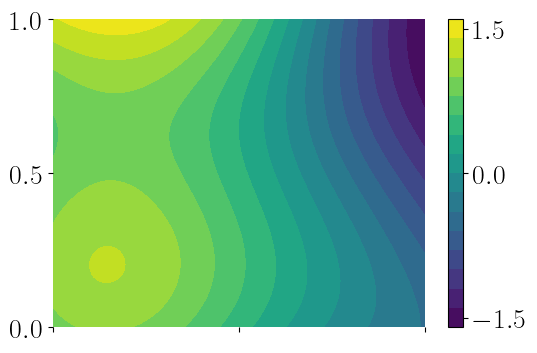

In [68]:
# u_true_ID plot
plt.figure(figsize=(6,4))
cp=plt.tricontourf(*xy_fine.T, darcy_u_true_ID,
                levels= 15)
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
plt.gca().set_xticklabels([]) 
# plt.gca().set_yticklabels([])
plt.savefig('darcy_u_true_ID0.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

In [69]:
# vmin and vmax to use same colors
fwd_ID_stacked = jnp.stack([darcy_P_fwd_error_ID_1step,
                            darcy_P_fwd_error_ID_2step])
vmin, vmax = jnp.min(fwd_ID_stacked), jnp.max(fwd_ID_stacked)

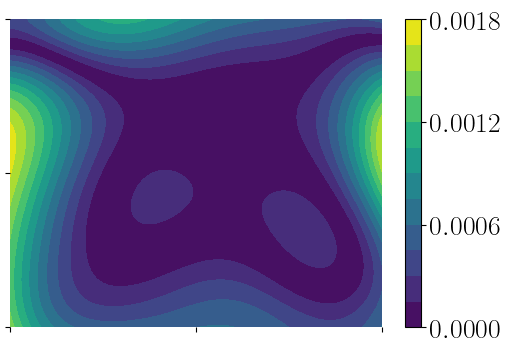

In [87]:
# P forward errors 1 step : P(u_ID) - Phat(u_ID)
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*xy_fine.T, darcy_P_fwd_error_ID_1step,
                levels= 15)
# colorbar
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
# save fig
plt.savefig('darcy_P_fwd_error_ID0_1step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            ) 

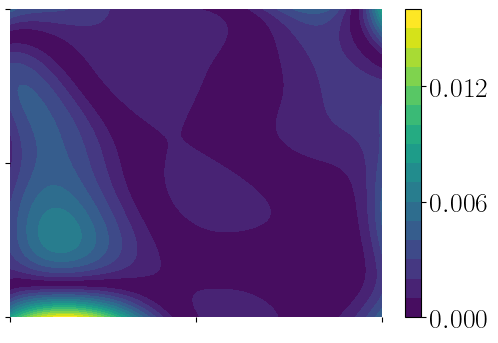

In [71]:
# P forward errors 2 step: P(u_ID) - Phat(u_ID)
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*xy_fine.T, darcy_P_fwd_error_ID_2step,
                levels= 15,
                vmin = vmin,
                vmax = vmax)
# colorbar
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
# save fig
plt.savefig('darcy_P_fwd_error_ID0_2step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            ) 

In [72]:
# vmin and vmax to use same colors
bwd_ID_stacked = jnp.stack([darcy_P_bwd_error_ID_1step,
                            darcy_P_bwd_error_ID_2step])
vmin, vmax = jnp.min(bwd_ID_stacked), jnp.max(bwd_ID_stacked)

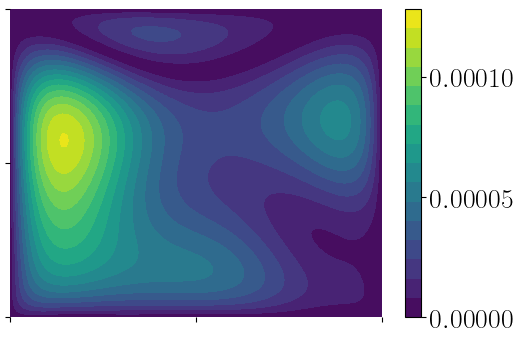

In [88]:
# P backward errors 1 step : u_ID - Phat^1Phat(u_ID)
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*xy_fine.T, darcy_P_bwd_error_ID_1step,
                    levels= 15)
# colorbar
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
# save fig
plt.savefig('darcy_P_bwd_error_ID0_1step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            ) 

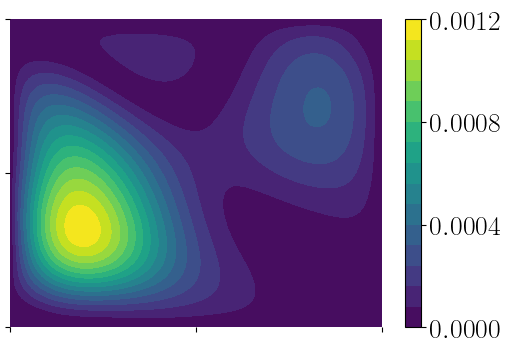

In [74]:
# P backward errors 2 step : u_ID - Phat^1Phat(u_ID)
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*xy_fine.T, darcy_P_bwd_error_ID_2step,
                    levels= 15,
                    vmin = vmin,
                    vmax = vmax)
# colorbar
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
# save fig
plt.savefig('darcy_P_bwd_error_ID0_2step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            ) 

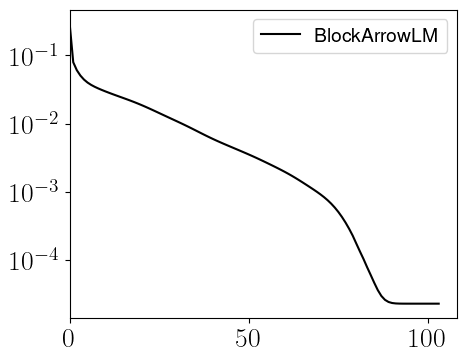

In [75]:
# loss history plot
plt.figure(figsize=(5,4))
plt.plot(range(len(loss_vals_ID_BlockArrowLM)),
         loss_vals_ID_BlockArrowLM,
         color = 'black',
         ls = 'solid',
         label = 'BlockArrowLM'
)

# fig settings
plt.locator_params(axis="x", nbins=3)
plt.locator_params(axis="y", nbins=2)
plt.xlim(left=0)
plt.yscale('log')
plt.legend(loc="upper right",fontsize = 14)
plt.minorticks_off()
#save fig
plt.savefig('darcy_loss_vals_ID0.pdf', 
            bbox_inches='tight',
            format = 'pdf',
            dpi=300)

## errors out-of-distribution (OOD): run = 0

In [76]:
# errors for OD - 1 step
m = 8
obs_pts = 8
run = 0
seed = int(m*obs_pts*(run+1))

# Sample m functions
kernel_GP = get_gaussianRBF(0.5)
xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
u_true_functions = tuple(GP_sampler(num_samples = m,
                                        X = xy_pairs, 
                                        kernel = kernel_GP,
                                        reg = 1e-12,
                                        seed = seed
                                    )
                                    )
# fine grid
xy_fine = jnp.vstack(build_xy_grid([0,1],[0,1],100,100))

# Permeability field A
def A(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

# Compute f = Pu for a given u
def get_rhs_darcy(u):
    def Agradu(xy):
        return A(xy)*jax.grad(u)(xy)
    def Pu(xy):
        return jnp.trace(jax.jacfwd(Agradu)(xy))
    return Pu

# Lists of m true u's and f's
vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed


# Sample collocation points for f using same uniform grid for every function
xy_int_single,xy_bdy_single = build_xy_grid([0,1],[0,1],10,10)
xy_ints = (xy_int_single,)*m
xy_bdys = (xy_bdy_single,)*m


xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

# List of number of observation points per u
num_obs = [obs_pts]*m

# Get (X^m, u^m(X^m))
xy_obs,u_obs = build_u_obs_all(
    num_obs,
    xy_ints,
    xy_bdys,
    vmapped_u_true_functions,
    pkey(seed)
)

# Build operator features
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

# Build interpolants for u's
k_u = get_gaussianRBF(0.5)
u_operators = (eval_k,)

# u_models = tuple([CholInducedRKHS(
#     xy_all[i],
#     u_operators,
#     k_u
#     ) for i in range(m)])

u_model = CholInducedRKHS(xy_all[0],u_operators,k_u)

# Get necessary tuples
observation_points = tuple(xy_obs)
observation_values = tuple(u_obs)
collocation_points = xy_ints


rhs_values = tuple(rhs_func(xy_int) for xy_int,rhs_func in zip(xy_ints,rhs_functions))

all_u_params_init = tuple([
    u_model.get_fitted_params(obs_loc,obs_val,lam = 1e-8)
    for obs_loc,obs_val in zip(observation_points,observation_values)])

grid_features_u_init = jnp.vstack([(
    u_model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for xy_int,model_params in zip(xy_ints,all_u_params_init) ])

grid_features_u_init = jnp.hstack([jnp.vstack(xy_ints),grid_features_u_init])

# P kernel
k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
k_P_x_part = get_gaussianRBF(0.4)

def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
    

# P object        
P_model = InducedOperatorModel(grid_features_u_init,k_P)
num_P_params = len(grid_features_u_init) 

# P, u, f object
collocation_points = xy_ints
EqnModel  = SharedOperatorPDEModel(
    P_model,
    u_model,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 5.,
    num_P_operator_params = 200
)

# OPTIMIZE

u_init = jnp.stack(all_u_params_init)
P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values),lam = 1e-4)

beta_reg = 1e-8

from Optimizers import BlockArrowLM,LMParams
lm_params = LMParams(max_iter = 501,init_alpha = 1e-1,min_alpha = 1e-12,print_every = 100)
u_sol,P_sol,arrow_conv = BlockArrowLM(
    u_init,P_init,EqnModel,beta_reg,beta_reg,
    optParams=lm_params
    )

# loss history
loss_vals_OOD_BlockArrowLM = arrow_conv.loss_vals

# Simulate u true OOD
kernel_GP_OOD = get_gaussianRBF(0.2) # Less regularity as training u's
u_true_OOD = GP_sampler(num_samples = 1,
                X = xy_pairs, 
                kernel = kernel_GP_OOD,
                reg = 1e-12,
                seed = seed
)
# P(u_OOD)(xy_fine)
P_true_OOD = jax.vmap(get_rhs_darcy(u_true_OOD[0]))(xy_fine)
# Phat[S] - 1 step    
P_func = lambda x: P_model.predict(x,P_sol)
# P[\phi(w)](fine_grid)
def evaluate_hatP(P_func, w, fine_grid, feature_operators):
    # Build S_test
    w_features = jnp.array([jax.vmap(operator(w,0))(xy_fine) for operator in feature_operators]).T
    model_fine_features = jnp.hstack([fine_grid, w_features])
    S_test = model_fine_features
    P_preds = P_func(S_test)
    return P_preds
# P_hat(u_OOD)(xy_fine)
P_pred_OOD = evaluate_hatP(P_func, 
                           u_true_OOD[0],
                           xy_fine,
                           feature_operators)

# Collocation points where to solve for \hat P (u) = f_new
num_interior_points = 256
num_grid_points = 20
# Sample collocation points for learning u
xy_interiors,xy_boundarys = sample_multiple_xy_grids_latin(
        num_functions = 1,
        num_interior = num_interior_points,
        x_range = [0,1],
        y_range = [0,1],
        num_grid_x_bdy = num_grid_points,
        num_grid_y_bdy = num_grid_points,
        key = pkey(0)
    )
# Boundary pairs
xy_bdy = xy_boundarys[0]
# Interior pairs (where PDE is satisfied)
xy_int = xy_interiors[0]
# Union of xy_bdy
xy_all = jnp.vstack([xy_int,xy_bdy])

# u_new object
u_model = CholInducedRKHS(
    xy_all,
    feature_operators,
    k_u
    )

def get_u_pde_adj(u_new,f_new):
        
    @jit
    def get_pred_hatP(input_features):
        return P_model.predict(input_features,P_sol)

    

    new_obs = u_new(xy_bdy) # Boundary conditions values that need to be satisfied


    class PdeModel():

        datafit_weight = 50.

        @jit
        def get_grid_features(u_params):
            evaluation = u_model.evaluate_operators(feature_operators,xy_int,u_params)
            grid_features = evaluation.reshape(len(xy_int),len(feature_operators),order = 'F')
            return jnp.hstack([xy_int,grid_features])
        
        @jit
        def get_grid_target(u_params):
            return f_new(xy_int)
        
        @jit
        def eval_obs_points(u_params):
            return u_model.point_evaluate(xy_bdy,u_params)
        
        @jit
        def datafit_residual(u_params):
            obs_preds = PdeModel.eval_obs_points(u_params)
            return new_obs - obs_preds
        
        @jit
        def equation_residual(u_params):
            P_features = PdeModel.get_grid_features(u_params)
            P_model_preds = get_pred_hatP(P_features)
            ugrid_target = PdeModel.get_grid_target(u_params)
            return (ugrid_target - P_model_preds)
        
        @jit
        def F(u_params):
            eqn_res = PdeModel.equation_residual(u_params)
            data_res = PdeModel.datafit_residual(u_params)
            return jnp.hstack([
                PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                eqn_res/jnp.sqrt(len(eqn_res))
                ])
        
        jac = jit(jacrev(F))

        def loss(u_params):
            return jnp.linalg.norm(PdeModel.F(u_params))**2
        
        @jit
        def damping_matrix(u_params):
            return u_model.kmat+1e-5 * diagpart(u_model.kmat)
    
    # Optimize
    new_u_init = jnp.zeros(xy_all.shape[0]*len(feature_operators))

    # Optimizer hyperparameters
    optparams = LMParams(max_iter = 301,
                        line_search_increase_ratio = 1.4,
                        print_every = 100,
                        tol = 1e-10)
    
    u_params_pde, _ = CholeskyLM(
        new_u_init.copy(),
        PdeModel,
        beta = 0,
        optParams = optparams
    )


    return u_params_pde
u_true_func = jax.vmap(u_true_OOD[0])
f_true_func = jax.vmap(get_rhs_darcy(u_true_OOD[0]))
u_pred_ol = u_model.point_evaluate(xy_fine,
                                   get_u_pde_adj(u_true_func,f_true_func)
)
# u_true_OOD vals at fine grid
darcy_u_true_OOD = jax.vmap(u_true_OOD[0])(xy_fine)
# relative error values: P(u_true_OOD) vs. Phat(u_true_OOD)
darcy_P_fwd_error_OOD_1step = jnp.abs(P_true_OOD - P_pred_OOD)/jnp.linalg.norm(P_true_OOD)
# relative error values: u_true_OOD vs. Phat^-1(P(u_true_OOD))
darcy_P_bwd_error_OOD_1step = jnp.abs(darcy_u_true_OOD - u_pred_ol)/jnp.linalg.norm(darcy_u_true_OOD)

  4%|▍         | 19/501 [00:02<00:51,  9.28it/s]

Iteration 0, loss = 0.07943, gradnorm = 1.661, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.06068, gradnorm = 0.06759, alpha = 0.06944, improvement_ratio = 1.001
Iteration 2, loss = 0.05061, gradnorm = 0.0347, alpha = 0.05787, improvement_ratio = 1.001
Iteration 3, loss = 0.04423, gradnorm = 0.0243, alpha = 0.04823, improvement_ratio = 1.001
Iteration 4, loss = 0.03999, gradnorm = 0.01778, alpha = 0.04019, improvement_ratio = 1.0
Iteration 5, loss = 0.03697, gradnorm = 0.01335, alpha = 0.03349, improvement_ratio = 1.0


 20%|██        | 102/501 [00:03<00:13, 30.56it/s]


Iteration 100, loss = 2.297e-05, gradnorm = 6.711e-08, alpha = 1.739e-09, improvement_ratio = 1.354


  3%|▎         | 10/301 [00:24<08:40,  1.79s/it] 

Iteration 0, loss = 912.4, gradnorm = 1.897e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 806.0, gradnorm = 0.2158, alpha = 2.083, improvement_ratio = 1.0
Iteration 2, loss = 738.3, gradnorm = 0.1365, alpha = 1.736, improvement_ratio = 1.0
Iteration 3, loss = 688.5, gradnorm = 0.1106, alpha = 1.447, improvement_ratio = 1.0
Iteration 4, loss = 649.9, gradnorm = 0.09224, alpha = 1.206, improvement_ratio = 1.0
Iteration 5, loss = 618.0, gradnorm = 0.07898, alpha = 1.005, improvement_ratio = 1.0


 36%|███▌      | 109/301 [00:25<00:04, 42.62it/s]

Iteration 100, loss = 23.38, gradnorm = 0.001326, alpha = 3.019e-08, improvement_ratio = 1.0


 72%|███████▏  | 217/301 [00:27<00:01, 82.59it/s]

Iteration 200, loss = 11.0, gradnorm = 0.01192, alpha = 8.333e-09, improvement_ratio = 1.001


100%|██████████| 301/301 [00:28<00:00, 10.66it/s]


Iteration 300, loss = 10.41, gradnorm = 0.003894, alpha = 8.333e-09, improvement_ratio = 0.9966


In [77]:
# errors for OOD - 2 step
m = 8
obs_pts = 8
run = 0
seed = int(m*obs_pts*(run+1))

# Sample m functions
kernel_GP = get_gaussianRBF(0.5)
xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
u_true_functions = tuple(GP_sampler(num_samples = m,
                                        X = xy_pairs, 
                                        kernel = kernel_GP,
                                        reg = 1e-12,
                                        seed = seed
                                    )
                                    )
# fine grid
xy_fine = jnp.vstack(build_xy_grid([0,1],[0,1],100,100))

# Permeability field A
def A(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

# Compute f = Pu for a given u
def get_rhs_darcy(u):
    def Agradu(xy):
        return A(xy)*jax.grad(u)(xy)
    def Pu(xy):
        return jnp.trace(jax.jacfwd(Agradu)(xy))
    return Pu

# Lists of m true u's and f's
vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed


# Sample collocation points for f using same uniform grid for every function
xy_int_single,xy_bdy_single = build_xy_grid([0,1],[0,1],10,10)
xy_ints = (xy_int_single,)*m
xy_bdys = (xy_bdy_single,)*m


xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

# List of number of observation points per u
num_obs = [obs_pts]*m

# Get (X^m, u^m(X^m))
xy_obs,u_obs = build_u_obs_all(
    num_obs,
    xy_ints,
    xy_bdys,
    vmapped_u_true_functions,
    pkey(seed)
)

# Build operator features
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

# Build interpolants for u's
k_u = get_gaussianRBF(0.5)
u_operators = (eval_k,)

# u_models = tuple([CholInducedRKHS(
#     xy_all[i],
#     u_operators,
#     k_u
#     ) for i in range(m)])

u_model = CholInducedRKHS(xy_all[0],u_operators,k_u)

# Get necessary tuples
observation_points = tuple(xy_obs)
observation_values = tuple(u_obs)
collocation_points = xy_ints


rhs_values = tuple(rhs_func(xy_int) for xy_int,rhs_func in zip(xy_ints,rhs_functions))

all_u_params_init = tuple([
    u_model.get_fitted_params(obs_loc,obs_val,lam = 1e-8)
    for obs_loc,obs_val in zip(observation_points,observation_values)])

grid_features_u_init = jnp.vstack([(
    u_model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for xy_int,model_params in zip(xy_ints,all_u_params_init) ])

grid_features_u_init = jnp.hstack([jnp.vstack(xy_ints),grid_features_u_init])

# P kernel
k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
k_P_x_part = get_gaussianRBF(0.4)

def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
    

# P object        
P_model = InducedOperatorModel(grid_features_u_init,k_P)
num_P_params = len(grid_features_u_init) 

# P, u, f object
collocation_points = xy_ints
EqnModel  = SharedOperatorPDEModel(
    P_model,
    u_model,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 5.,
    num_P_operator_params = 200
)

# u_init = jnp.stack(all_u_params_init)
# P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values),lam = 1e-4)

# beta_reg = 1e-8

# from Optimizers import BlockArrowLM,LMParams
# lm_params = LMParams(max_iter = 501,init_alpha = 1e-1,min_alpha = 1e-12,print_every = 100)
# u_sol,P_sol,arrow_conv = BlockArrowLM(
#     u_init,P_init,EqnModel,beta_reg,beta_reg,
#     optParams=lm_params
#     )

# Simulate u true OOD
kernel_GP_OOD = get_gaussianRBF(0.2) # Less regularity as training u's
u_true_OOD = GP_sampler(num_samples = 1,
                X = xy_pairs, 
                kernel = kernel_GP_OOD,
                reg = 1e-12,
                seed = seed
)
# P(u_OOD)(xy_fine)
P_true_OOD = jax.vmap(get_rhs_darcy(u_true_OOD[0]))(xy_fine)

# Phat[S] - 2 step
init_P_features = jnp.vstack([EqnModel.single_eqn_features(u_params,eval_points) 
                                        for u_params,eval_points in zip(
                                        all_u_params_init,
                                        EqnModel.collocation_points)])
rhs_stacked = EqnModel.stacked_collocation_rhs
P_params_naive = P_model.get_fitted_params(init_P_features,rhs_stacked)
P_func2 = lambda x: P_model.predict(x,P_params_naive)

# P[\phi(w)](fine_grid)
def evaluate_hatP(P_func, w, fine_grid, feature_operators):
    # Build S_test
    w_features = jnp.array([jax.vmap(operator(w,0))(xy_fine) for operator in feature_operators]).T
    model_fine_features = jnp.hstack([fine_grid, w_features])
    S_test = model_fine_features
    P_preds = P_func(S_test)
    return P_preds
# P_hat(u_OOD)(xy_fine)
P_pred_OOD = evaluate_hatP(P_func2, 
                           u_true_OOD[0],
                           xy_fine,
                           feature_operators)

# Collocation points where to solve for \hat P (u) = f_new
num_interior_points = 256
num_grid_points = 20
# Sample collocation points for learning u
xy_interiors,xy_boundarys = sample_multiple_xy_grids_latin(
        num_functions = 1,
        num_interior = num_interior_points,
        x_range = [0,1],
        y_range = [0,1],
        num_grid_x_bdy = num_grid_points,
        num_grid_y_bdy = num_grid_points,
        key = pkey(0)
    )
# Boundary pairs
xy_bdy = xy_boundarys[0]
# Interior pairs (where PDE is satisfied)
xy_int = xy_interiors[0]
# Union of xy_bdy
xy_all = jnp.vstack([xy_int,xy_bdy])

# u_new object
u_model = CholInducedRKHS(
    xy_all,
    feature_operators,
    k_u
    )

def get_u_pde_adj(u_new,f_new):
        
    @jit
    def get_pred_hatP2step(input_features):
        init_P_features = jnp.vstack([EqnModel.single_eqn_features(u_params,eval_points) 
                                                for u_params,eval_points in zip(
                                                all_u_params_init,
                                                EqnModel.collocation_points)])
        rhs_stacked = EqnModel.stacked_collocation_rhs
        P_params_naive = P_model.get_fitted_params(init_P_features,rhs_stacked)
        return P_model.predict(input_features,P_params_naive)

    

    new_obs = u_new(xy_bdy) # Boundary conditions values that need to be satisfied


    class PdeModel():

        datafit_weight = 50.

        @jit
        def get_grid_features(u_params):
            evaluation = u_model.evaluate_operators(feature_operators,xy_int,u_params)
            grid_features = evaluation.reshape(len(xy_int),len(feature_operators),order = 'F')
            return jnp.hstack([xy_int,grid_features])
        
        @jit
        def get_grid_target(u_params):
            return f_new(xy_int)
        
        @jit
        def eval_obs_points(u_params):
            return u_model.point_evaluate(xy_bdy,u_params)
        
        @jit
        def datafit_residual(u_params):
            obs_preds = PdeModel.eval_obs_points(u_params)
            return new_obs - obs_preds
        
        @jit
        def equation_residual(u_params):
            P_features = PdeModel.get_grid_features(u_params)
            P_model_preds = get_pred_hatP2step(P_features)
            ugrid_target = PdeModel.get_grid_target(u_params)
            return (ugrid_target - P_model_preds)
        
        @jit
        def F(u_params):
            eqn_res = PdeModel.equation_residual(u_params)
            data_res = PdeModel.datafit_residual(u_params)
            return jnp.hstack([
                PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                eqn_res/jnp.sqrt(len(eqn_res))
                ])
        
        jac = jit(jacrev(F))

        def loss(u_params):
            return jnp.linalg.norm(PdeModel.F(u_params))**2
        
        @jit
        def damping_matrix(u_params):
            return u_model.kmat+1e-5 * diagpart(u_model.kmat)
    
    # Optimize
    new_u_init = jnp.zeros(xy_all.shape[0]*len(feature_operators))

    # Optimizer hyperparameters
    optparams = LMParams(max_iter = 301,
                        line_search_increase_ratio = 1.4,
                        print_every = 100,
                        tol = 1e-10)
    
    u_params_pde, _ = CholeskyLM(
        new_u_init.copy(),
        PdeModel,
        beta = 0,
        optParams = optparams
    )


    return u_params_pde

u_true_func = jax.vmap(u_true_OOD[0])
f_true_func = jax.vmap(get_rhs_darcy(u_true_OOD[0]))
u_pred_ol = u_model.point_evaluate(xy_fine,
                                   get_u_pde_adj(u_true_func,f_true_func)
)
# u_true_OOD vals at fine grid
darcy_u_true_OOD = jax.vmap(u_true_OOD[0])(xy_fine)
# relative error values: P(u_true_OOD) vs. Phat(u_true_OOD)
darcy_P_fwd_error_OOD_2step = jnp.abs(P_true_OOD - P_pred_OOD)/jnp.linalg.norm(P_true_OOD)
# relative error values: u_true_OOD vs. Phat^-1(P(u_true_OOD))
darcy_P_bwd_error_OOD_2step = jnp.abs(darcy_u_true_OOD - u_pred_ol)/jnp.linalg.norm(darcy_u_true_OOD)

  0%|          | 1/301 [00:26<2:10:03, 26.01s/it]

Iteration 0, loss = 829.7, gradnorm = 1.855e+03, alpha = 2.5, improvement_ratio = 1.0


  1%|          | 2/301 [00:26<54:08, 10.87s/it]  

Iteration 1, loss = 748.5, gradnorm = 0.1908, alpha = 2.083, improvement_ratio = 1.0


  1%|          | 3/301 [00:26<29:55,  6.02s/it]

Iteration 2, loss = 698.8, gradnorm = 0.1143, alpha = 1.736, improvement_ratio = 1.0


  1%|▏         | 4/301 [00:26<18:33,  3.75s/it]

Iteration 3, loss = 663.1, gradnorm = 0.09142, alpha = 1.447, improvement_ratio = 1.0


  2%|▏         | 5/301 [00:27<12:17,  2.49s/it]

Iteration 4, loss = 636.5, gradnorm = 0.07526, alpha = 1.206, improvement_ratio = 1.0


  2%|▏         | 6/301 [00:27<08:31,  1.73s/it]

Iteration 5, loss = 615.7, gradnorm = 0.06359, alpha = 1.005, improvement_ratio = 1.0


 34%|███▎      | 101/301 [00:52<00:52,  3.83it/s]

Iteration 100, loss = 25.66, gradnorm = 0.001745, alpha = 3.019e-08, improvement_ratio = 1.0


 67%|██████▋   | 201/301 [01:18<00:26,  3.83it/s]

Iteration 200, loss = 15.55, gradnorm = 0.006489, alpha = 8.333e-09, improvement_ratio = 0.9991


100%|██████████| 301/301 [01:44<00:00,  2.88it/s]

Iteration 300, loss = 14.79, gradnorm = 0.01171, alpha = 8.333e-09, improvement_ratio = 1.001


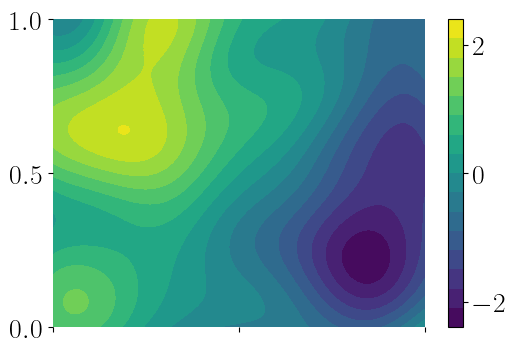

In [78]:
# u_true_OOD plot
plt.figure(figsize=(6,4))
cp=plt.tricontourf(*xy_fine.T, darcy_u_true_OOD,
                levels= 15)
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
plt.gca().set_xticklabels([]) 
# plt.gca().set_yticklabels([])
plt.savefig('darcy_u_true_OOD0.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

In [79]:
# vmin and vmax to use same colors
fwd_OOD_stacked = jnp.stack([darcy_P_fwd_error_OOD_1step,
                            darcy_P_fwd_error_OOD_2step])
vmin, vmax = jnp.min(fwd_OOD_stacked), jnp.max(fwd_OOD_stacked)

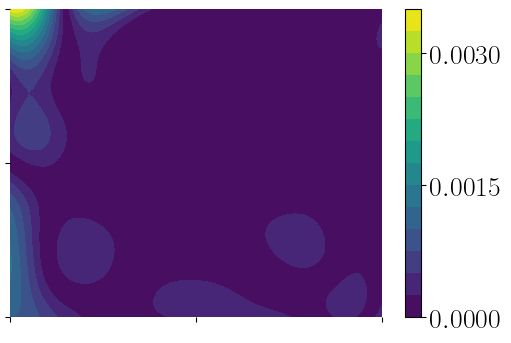

In [89]:
# P forward errors 1 step: P(u_OOD) - Phat(u_OOD)
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*xy_fine.T, darcy_P_fwd_error_OOD_1step,
                    levels= 15)
# colorbar
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
# save fig
plt.savefig('darcy_P_fwd_error_OOD0_1step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            ) 

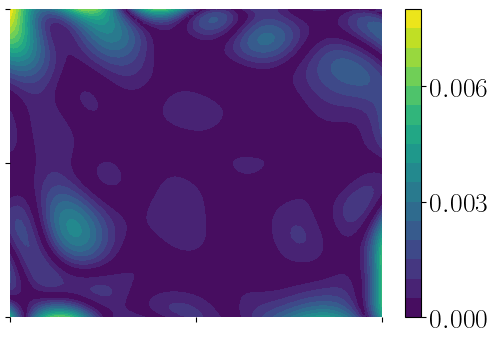

In [81]:
# P forward errors 2 step: P(u_OOD) - Phat(u_OOD)
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*xy_fine.T, darcy_P_fwd_error_OOD_2step,
                    levels= 15)
# colorbar
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
# save fig
plt.savefig('darcy_P_fwd_error_OOD0_2step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            ) 

In [82]:
# vmin and vmax to use same colors
bwd_OOD_stacked = jnp.stack([darcy_P_bwd_error_OOD_1step,
                            darcy_P_bwd_error_OOD_2step])
vmin, vmax = jnp.min(bwd_OOD_stacked), jnp.max(bwd_OOD_stacked)

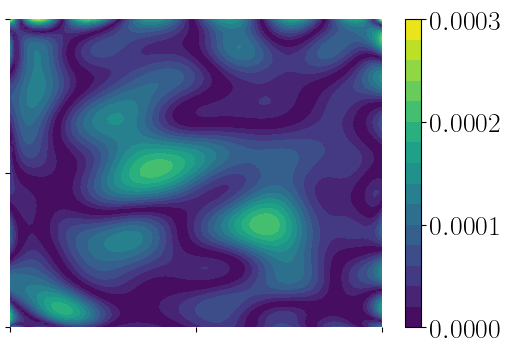

In [90]:
# P backward errors 1 step: u_OOD - Phat^1Phat(u_OOD)
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*xy_fine.T, darcy_P_bwd_error_OOD_1step,
                    levels= 15)
# colorbar
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
# save fig
plt.savefig('darcy_P_bwd_error_OOD0_1step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            ) 

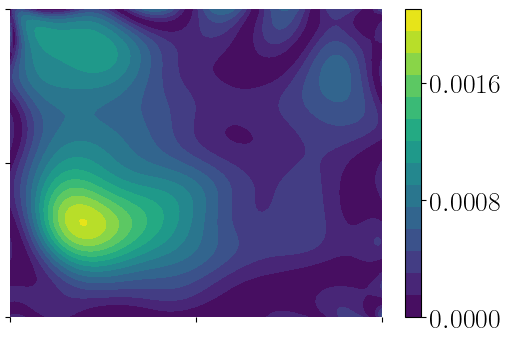

In [85]:
# P backward errors 2 step: u_OOD - Phat^1Phat(u_OOD)
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*xy_fine.T, darcy_P_bwd_error_OOD_2step,
                    levels= 15)
# colorbar
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
# save fig
plt.savefig('darcy_P_bwd_error_OOD0_2step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            ) 

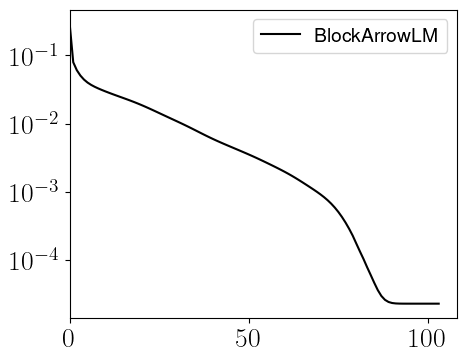

In [86]:
# loss history plot
plt.figure(figsize=(5,4))
plt.plot(range(len(loss_vals_OOD_BlockArrowLM)),
         loss_vals_OOD_BlockArrowLM,
         color = 'black',
         ls = 'solid',
         label = 'BlockArrowLM'
)

# fig settings
plt.locator_params(axis="x", nbins=3)
plt.locator_params(axis="y", nbins=2)
plt.xlim(left=0)
plt.yscale('log')
plt.legend(loc="upper right",fontsize = 14)
plt.minorticks_off()
#save fig
plt.savefig('darcy_loss_vals_OOD0.pdf', 
            bbox_inches='tight',
            format = 'pdf',
            dpi=300)

## errors in-distribution(ID): run = 1

In [91]:
# errors for ID - 1 step
m = 8
obs_pts = 8
run = 1
seed = int(m*obs_pts*(run+1))

# Sample m functions
kernel_GP = get_gaussianRBF(0.5)
xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
u_true_functions = tuple(GP_sampler(num_samples = m,
                                        X = xy_pairs, 
                                        kernel = kernel_GP,
                                        reg = 1e-12,
                                        seed = seed
                                    )
                                    )
# fine grid
xy_fine = jnp.vstack(build_xy_grid([0,1],[0,1],100,100))

# Permeability field A
def A(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

# Compute f = Pu for a given u
def get_rhs_darcy(u):
    def Agradu(xy):
        return A(xy)*jax.grad(u)(xy)
    def Pu(xy):
        return jnp.trace(jax.jacfwd(Agradu)(xy))
    return Pu

# Lists of m true u's and f's
vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed


# Sample collocation points for f using same uniform grid for every function
xy_int_single,xy_bdy_single = build_xy_grid([0,1],[0,1],10,10)
xy_ints = (xy_int_single,)*m
xy_bdys = (xy_bdy_single,)*m


xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

# List of number of observation points per u
num_obs = [obs_pts]*m

# Get (X^m, u^m(X^m))
xy_obs,u_obs = build_u_obs_all(
    num_obs,
    xy_ints,
    xy_bdys,
    vmapped_u_true_functions,
    pkey(seed)
)

# Build operator features
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

# Build interpolants for u's
k_u = get_gaussianRBF(0.5)
u_operators = (eval_k,)

# u_models = tuple([CholInducedRKHS(
#     xy_all[i],
#     u_operators,
#     k_u
#     ) for i in range(m)])

u_model = CholInducedRKHS(xy_all[0],u_operators,k_u)

# Get necessary tuples
observation_points = tuple(xy_obs)
observation_values = tuple(u_obs)
collocation_points = xy_ints


rhs_values = tuple(rhs_func(xy_int) for xy_int,rhs_func in zip(xy_ints,rhs_functions))

all_u_params_init = tuple([
    u_model.get_fitted_params(obs_loc,obs_val,lam = 1e-8)
    for obs_loc,obs_val in zip(observation_points,observation_values)])

grid_features_u_init = jnp.vstack([(
    u_model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for xy_int,model_params in zip(xy_ints,all_u_params_init) ])

grid_features_u_init = jnp.hstack([jnp.vstack(xy_ints),grid_features_u_init])

# P kernel
k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
k_P_x_part = get_gaussianRBF(0.4)

def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
    

# P object        
P_model = InducedOperatorModel(grid_features_u_init,k_P)
num_P_params = len(grid_features_u_init) 

# P, u, f object
collocation_points = xy_ints
EqnModel  = SharedOperatorPDEModel(
    P_model,
    u_model,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 5.,
    num_P_operator_params = 200
)

# OPTIMIZE

u_init = jnp.stack(all_u_params_init)
P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values),lam = 1e-4)

beta_reg = 1e-8

from Optimizers import BlockArrowLM,LMParams
lm_params = LMParams(max_iter = 501,init_alpha = 1e-1,min_alpha = 1e-12,print_every = 100)
u_sol,P_sol,arrow_conv = BlockArrowLM(
    u_init,P_init,EqnModel,beta_reg,beta_reg,
    optParams=lm_params
    )

# loss history
loss_vals_ID_BlockArrowLM = arrow_conv.loss_vals


# Simulate u true ID
kernel_GP_ID = get_gaussianRBF(0.5) # Same regularity as training u's
# Sample M training functions from GP(0,K)
u_true_ID = GP_sampler(num_samples = 1,
                X = xy_pairs, 
                kernel = kernel_GP_ID,
                reg = 1e-12,
                seed = seed
)
# P(u_ID)(xy_fine)
P_true_ID = jax.vmap(get_rhs_darcy(u_true_ID[0]))(xy_fine)
# Phat[S] - 1 step    
P_func = lambda x: P_model.predict(x,P_sol)
# P[\phi(w)](fine_grid)
def evaluate_hatP(P_func, w, fine_grid, feature_operators):
    # Build S_test
    w_features = jnp.array([jax.vmap(operator(w,0))(xy_fine) for operator in feature_operators]).T
    model_fine_features = jnp.hstack([fine_grid, w_features])
    S_test = model_fine_features
    P_preds = P_func(S_test)
    return P_preds
# P_hat(u_ID)(xy_fine)
P_pred_ID = evaluate_hatP(P_func, 
                           u_true_ID[0],
                           xy_fine,
                           feature_operators)

# Collocation points where to solve for \hat P (u) = f_new
num_interior_points = 256
num_grid_points = 20
# Sample collocation points for learning u
xy_interiors,xy_boundarys = sample_multiple_xy_grids_latin(
        num_functions = 1,
        num_interior = num_interior_points,
        x_range = [0,1],
        y_range = [0,1],
        num_grid_x_bdy = num_grid_points,
        num_grid_y_bdy = num_grid_points,
        key = pkey(0)
    )
# Boundary pairs
xy_bdy = xy_boundarys[0]
# Interior pairs (where PDE is satisfied)
xy_int = xy_interiors[0]
# Union of xy_bdy
xy_all = jnp.vstack([xy_int,xy_bdy])

# u_new object
u_model = CholInducedRKHS(
    xy_all,
    feature_operators,
    k_u
    )

def get_u_pde_adj(u_new,f_new):
        
    @jit
    def get_pred_hatP(input_features):
        return P_model.predict(input_features,P_sol)

    

    new_obs = u_new(xy_bdy) # Boundary conditions values that need to be satisfied


    class PdeModel():

        datafit_weight = 50.

        @jit
        def get_grid_features(u_params):
            evaluation = u_model.evaluate_operators(feature_operators,xy_int,u_params)
            grid_features = evaluation.reshape(len(xy_int),len(feature_operators),order = 'F')
            return jnp.hstack([xy_int,grid_features])
        
        @jit
        def get_grid_target(u_params):
            return f_new(xy_int)
        
        @jit
        def eval_obs_points(u_params):
            return u_model.point_evaluate(xy_bdy,u_params)
        
        @jit
        def datafit_residual(u_params):
            obs_preds = PdeModel.eval_obs_points(u_params)
            return new_obs - obs_preds
        
        @jit
        def equation_residual(u_params):
            P_features = PdeModel.get_grid_features(u_params)
            P_model_preds = get_pred_hatP(P_features)
            ugrid_target = PdeModel.get_grid_target(u_params)
            return (ugrid_target - P_model_preds)
        
        @jit
        def F(u_params):
            eqn_res = PdeModel.equation_residual(u_params)
            data_res = PdeModel.datafit_residual(u_params)
            return jnp.hstack([
                PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                eqn_res/jnp.sqrt(len(eqn_res))
                ])
        
        jac = jit(jacrev(F))

        def loss(u_params):
            return jnp.linalg.norm(PdeModel.F(u_params))**2
        
        @jit
        def damping_matrix(u_params):
            return u_model.kmat+1e-5 * diagpart(u_model.kmat)
    
    # Optimize
    new_u_init = jnp.zeros(xy_all.shape[0]*len(feature_operators))

    # Optimizer hyperparameters
    optparams = LMParams(max_iter = 301,
                        line_search_increase_ratio = 1.4,
                        print_every = 100,
                        tol = 1e-10)
    
    u_params_pde, _ = CholeskyLM(
        new_u_init.copy(),
        PdeModel,
        beta = 0,
        optParams = optparams
    )


    return u_params_pde
u_true_func = jax.vmap(u_true_ID[0])
f_true_func = jax.vmap(get_rhs_darcy(u_true_ID[0]))
u_pred_ol = u_model.point_evaluate(xy_fine,
                                   get_u_pde_adj(u_true_func,f_true_func)
)
# u_true_ID vals at fine grid
darcy_u_true_ID = jax.vmap(u_true_ID[0])(xy_fine)
# relative error values: P(u_true_ID) vs. Phat(u_true_ID)
darcy_P_fwd_error_ID_1step = jnp.abs(P_true_ID - P_pred_ID)/jnp.linalg.norm(P_true_ID)
# relative error values: u_true_ID vs. Phat^-1(P(u_true_ID))
darcy_P_bwd_error_ID_1step = jnp.abs(darcy_u_true_ID - u_pred_ol)/jnp.linalg.norm(darcy_u_true_ID)

  4%|▍         | 19/501 [00:02<00:46, 10.28it/s]

Iteration 0, loss = 0.0833, gradnorm = 2.28, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.0664, gradnorm = 0.06851, alpha = 0.06944, improvement_ratio = 1.001
Iteration 2, loss = 0.05757, gradnorm = 0.03235, alpha = 0.05787, improvement_ratio = 1.001
Iteration 3, loss = 0.05142, gradnorm = 0.02292, alpha = 0.04823, improvement_ratio = 1.001
Iteration 4, loss = 0.04664, gradnorm = 0.0178, alpha = 0.04019, improvement_ratio = 1.001
Iteration 5, loss = 0.04265, gradnorm = 0.01448, alpha = 0.03349, improvement_ratio = 1.001


  3%|▎         | 10/301 [00:24<08:25,  1.74s/it] 

Iteration 0, loss = 0.000708, gradnorm = 892.0, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 0.0005421, gradnorm = 0.0003748, alpha = 2.083, improvement_ratio = 1.0
Iteration 2, loss = 0.0004835, gradnorm = 0.0001198, alpha = 1.736, improvement_ratio = 1.0
Iteration 3, loss = 0.0004385, gradnorm = 9.21e-05, alpha = 1.447, improvement_ratio = 1.0
Iteration 4, loss = 0.0003981, gradnorm = 8.033e-05, alpha = 1.206, improvement_ratio = 1.0
Iteration 5, loss = 0.0003602, gradnorm = 7.21e-05, alpha = 1.005, improvement_ratio = 1.0


 36%|███▌      | 109/301 [00:25<00:04, 43.26it/s]

Iteration 100, loss = 5.644e-06, gradnorm = 4.766e-07, alpha = 3.019e-08, improvement_ratio = 1.0


 72%|███████▏  | 217/301 [00:26<00:01, 82.64it/s]

Iteration 200, loss = 3.49e-06, gradnorm = 1.088e-06, alpha = 8.333e-09, improvement_ratio = 0.9976


100%|██████████| 301/301 [00:27<00:00, 10.95it/s]


Iteration 300, loss = 3.386e-06, gradnorm = 9.695e-07, alpha = 8.333e-09, improvement_ratio = 1.015


In [92]:
# errors for ID - 2 step
m = 8
obs_pts = 8
run = 1
seed = int(m*obs_pts*(run+1))

# Sample m functions
kernel_GP = get_gaussianRBF(0.5)
xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
u_true_functions = tuple(GP_sampler(num_samples = m,
                                        X = xy_pairs, 
                                        kernel = kernel_GP,
                                        reg = 1e-12,
                                        seed = seed
                                    )
                                    )
# fine grid
xy_fine = jnp.vstack(build_xy_grid([0,1],[0,1],100,100))

# Permeability field A
def A(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

# Compute f = Pu for a given u
def get_rhs_darcy(u):
    def Agradu(xy):
        return A(xy)*jax.grad(u)(xy)
    def Pu(xy):
        return jnp.trace(jax.jacfwd(Agradu)(xy))
    return Pu

# Lists of m true u's and f's
vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed


# Sample collocation points for f using same uniform grid for every function
xy_int_single,xy_bdy_single = build_xy_grid([0,1],[0,1],10,10)
xy_ints = (xy_int_single,)*m
xy_bdys = (xy_bdy_single,)*m


xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

# List of number of observation points per u
num_obs = [obs_pts]*m

# Get (X^m, u^m(X^m))
xy_obs,u_obs = build_u_obs_all(
    num_obs,
    xy_ints,
    xy_bdys,
    vmapped_u_true_functions,
    pkey(seed)
)

# Build operator features
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

# Build interpolants for u's
k_u = get_gaussianRBF(0.5)
u_operators = (eval_k,)

# u_models = tuple([CholInducedRKHS(
#     xy_all[i],
#     u_operators,
#     k_u
#     ) for i in range(m)])

u_model = CholInducedRKHS(xy_all[0],u_operators,k_u)

# Get necessary tuples
observation_points = tuple(xy_obs)
observation_values = tuple(u_obs)
collocation_points = xy_ints


rhs_values = tuple(rhs_func(xy_int) for xy_int,rhs_func in zip(xy_ints,rhs_functions))

all_u_params_init = tuple([
    u_model.get_fitted_params(obs_loc,obs_val,lam = 1e-8)
    for obs_loc,obs_val in zip(observation_points,observation_values)])

grid_features_u_init = jnp.vstack([(
    u_model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for xy_int,model_params in zip(xy_ints,all_u_params_init) ])

grid_features_u_init = jnp.hstack([jnp.vstack(xy_ints),grid_features_u_init])

# P kernel
k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
k_P_x_part = get_gaussianRBF(0.4)

def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
    

# P object        
P_model = InducedOperatorModel(grid_features_u_init,k_P)
num_P_params = len(grid_features_u_init) 

# P, u, f object
collocation_points = xy_ints
EqnModel  = SharedOperatorPDEModel(
    P_model,
    u_model,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 5.,
    num_P_operator_params = 200
)

# u_init = jnp.stack(all_u_params_init)
# P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values),lam = 1e-4)

# beta_reg = 1e-8

# from Optimizers import BlockArrowLM,LMParams
# lm_params = LMParams(max_iter = 501,init_alpha = 1e-1,min_alpha = 1e-12,print_every = 100)
# u_sol,P_sol,arrow_conv = BlockArrowLM(
#     u_init,P_init,EqnModel,beta_reg,beta_reg,
#     optParams=lm_params
#     )

# Simulate u true ID
kernel_GP_ID = get_gaussianRBF(0.5) # Same regularity as training u's
# Sample M training functions from GP(0,K)
u_true_ID = GP_sampler(num_samples = 1,
                X = xy_pairs, 
                kernel = kernel_GP_ID,
                reg = 1e-12,
                seed = seed
)
# P(u_ID)(xy_fine)
P_true_ID = jax.vmap(get_rhs_darcy(u_true_ID[0]))(xy_fine)

# Phat[S] - 2 step
init_P_features = jnp.vstack([EqnModel.single_eqn_features(u_params,eval_points) 
                                        for u_params,eval_points in zip(
                                        all_u_params_init,
                                        EqnModel.collocation_points)])
rhs_stacked = EqnModel.stacked_collocation_rhs
P_params_naive = P_model.get_fitted_params(init_P_features,rhs_stacked)
P_func2 = lambda x: P_model.predict(x,P_params_naive)

# P[\phi(w)](fine_grid)
def evaluate_hatP(P_func, w, fine_grid, feature_operators):
    # Build S_test
    w_features = jnp.array([jax.vmap(operator(w,0))(xy_fine) for operator in feature_operators]).T
    model_fine_features = jnp.hstack([fine_grid, w_features])
    S_test = model_fine_features
    P_preds = P_func(S_test)
    return P_preds
# P_hat(u_ID)(xy_fine)
P_pred_ID = evaluate_hatP(P_func2, 
                           u_true_ID[0],
                           xy_fine,
                           feature_operators)

# Collocation points where to solve for \hat P (u) = f_new
num_interior_points = 256
num_grid_points = 20
# Sample collocation points for learning u
xy_interiors,xy_boundarys = sample_multiple_xy_grids_latin(
        num_functions = 1,
        num_interior = num_interior_points,
        x_range = [0,1],
        y_range = [0,1],
        num_grid_x_bdy = num_grid_points,
        num_grid_y_bdy = num_grid_points,
        key = pkey(0)
    )
# Boundary pairs
xy_bdy = xy_boundarys[0]
# Interior pairs (where PDE is satisfied)
xy_int = xy_interiors[0]
# Union of xy_bdy
xy_all = jnp.vstack([xy_int,xy_bdy])

# u_new object
u_model = CholInducedRKHS(
    xy_all,
    feature_operators,
    k_u
    )

def get_u_pde_adj(u_new,f_new):
        
    @jit
    def get_pred_hatP2step(input_features):
        init_P_features = jnp.vstack([EqnModel.single_eqn_features(u_params,eval_points) 
                                                for u_params,eval_points in zip(
                                                all_u_params_init,
                                                EqnModel.collocation_points)])
        rhs_stacked = EqnModel.stacked_collocation_rhs
        P_params_naive = P_model.get_fitted_params(init_P_features,rhs_stacked)
        return P_model.predict(input_features,P_params_naive)

    

    new_obs = u_new(xy_bdy) # Boundary conditions values that need to be satisfied


    class PdeModel():

        datafit_weight = 50.

        @jit
        def get_grid_features(u_params):
            evaluation = u_model.evaluate_operators(feature_operators,xy_int,u_params)
            grid_features = evaluation.reshape(len(xy_int),len(feature_operators),order = 'F')
            return jnp.hstack([xy_int,grid_features])
        
        @jit
        def get_grid_target(u_params):
            return f_new(xy_int)
        
        @jit
        def eval_obs_points(u_params):
            return u_model.point_evaluate(xy_bdy,u_params)
        
        @jit
        def datafit_residual(u_params):
            obs_preds = PdeModel.eval_obs_points(u_params)
            return new_obs - obs_preds
        
        @jit
        def equation_residual(u_params):
            P_features = PdeModel.get_grid_features(u_params)
            P_model_preds = get_pred_hatP2step(P_features)
            ugrid_target = PdeModel.get_grid_target(u_params)
            return (ugrid_target - P_model_preds)
        
        @jit
        def F(u_params):
            eqn_res = PdeModel.equation_residual(u_params)
            data_res = PdeModel.datafit_residual(u_params)
            return jnp.hstack([
                PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                eqn_res/jnp.sqrt(len(eqn_res))
                ])
        
        jac = jit(jacrev(F))

        def loss(u_params):
            return jnp.linalg.norm(PdeModel.F(u_params))**2
        
        @jit
        def damping_matrix(u_params):
            return u_model.kmat+1e-5 * diagpart(u_model.kmat)
    
    # Optimize
    new_u_init = jnp.zeros(xy_all.shape[0]*len(feature_operators))

    # Optimizer hyperparameters
    optparams = LMParams(max_iter = 301,
                        line_search_increase_ratio = 1.4,
                        print_every = 100,
                        tol = 1e-10)
    
    u_params_pde, _ = CholeskyLM(
        new_u_init.copy(),
        PdeModel,
        beta = 0,
        optParams = optparams
    )


    return u_params_pde

u_true_func = jax.vmap(u_true_ID[0])
f_true_func = jax.vmap(get_rhs_darcy(u_true_ID[0]))
u_pred_ol = u_model.point_evaluate(xy_fine,
                                   get_u_pde_adj(u_true_func,f_true_func)
)
# u_true_ID vals at fine grid
darcy_u_true_ID = jax.vmap(u_true_ID[0])(xy_fine)
# relative error values: P(u_true_ID) vs. Phat(u_true_ID)
darcy_P_fwd_error_ID_2step = jnp.abs(P_true_ID - P_pred_ID)/jnp.linalg.norm(P_true_ID)
# relative error values: u_true_ID vs. Phat^-1(P(u_true_ID))
darcy_P_bwd_error_ID_2step = jnp.abs(darcy_u_true_ID - u_pred_ol)/jnp.linalg.norm(darcy_u_true_ID)

  0%|          | 1/301 [00:26<2:11:45, 26.35s/it]

Iteration 0, loss = 1.424, gradnorm = 888.5, alpha = 2.5, improvement_ratio = 1.0


  1%|          | 2/301 [00:26<54:51, 11.01s/it]  

Iteration 1, loss = 1.303, gradnorm = 0.005651, alpha = 2.083, improvement_ratio = 1.0


  1%|          | 3/301 [00:26<30:18,  6.10s/it]

Iteration 2, loss = 1.231, gradnorm = 0.003636, alpha = 1.736, improvement_ratio = 1.0


  1%|▏         | 4/301 [00:27<18:47,  3.80s/it]

Iteration 3, loss = 1.18, gradnorm = 0.002845, alpha = 1.447, improvement_ratio = 1.0


  2%|▏         | 5/301 [00:27<12:26,  2.52s/it]

Iteration 4, loss = 1.143, gradnorm = 0.002324, alpha = 1.206, improvement_ratio = 1.0


  2%|▏         | 6/301 [00:27<08:37,  1.75s/it]

Iteration 5, loss = 1.113, gradnorm = 0.001973, alpha = 1.005, improvement_ratio = 1.0


 34%|███▎      | 101/301 [00:52<00:52,  3.79it/s]

Iteration 100, loss = 0.2532, gradnorm = 5.252e-05, alpha = 3.019e-08, improvement_ratio = 1.0


 67%|██████▋   | 201/301 [01:19<00:26,  3.79it/s]

Iteration 200, loss = 0.2133, gradnorm = 0.0004204, alpha = 8.333e-09, improvement_ratio = 0.9957


100%|██████████| 301/301 [01:45<00:00,  2.85it/s]

Iteration 300, loss = 0.2092, gradnorm = 0.0004883, alpha = 8.333e-09, improvement_ratio = 0.9911


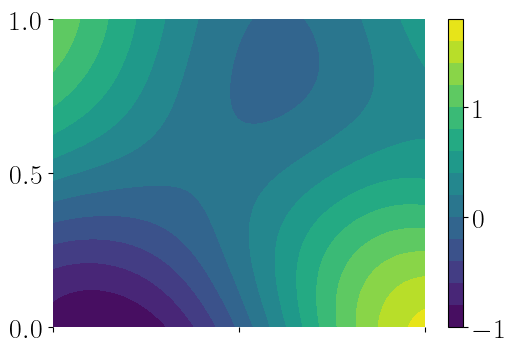

In [93]:
# u_true_ID plot
plt.figure(figsize=(6,4))
cp=plt.tricontourf(*xy_fine.T, darcy_u_true_ID,
                levels= 15)
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
plt.gca().set_xticklabels([]) 
# plt.gca().set_yticklabels([])
plt.savefig('darcy_u_true_ID1.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

In [94]:
# vmin and vmax to use same colors
fwd_ID_stacked = jnp.stack([darcy_P_fwd_error_ID_1step,
                            darcy_P_fwd_error_ID_2step])
vmin, vmax = jnp.min(fwd_ID_stacked), jnp.max(fwd_ID_stacked)

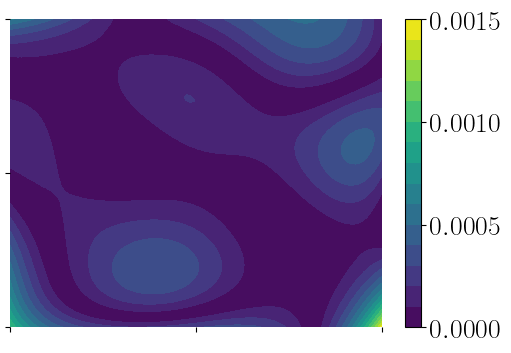

In [95]:
# P forward errors 1 step : P(u_ID) - Phat(u_ID)
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*xy_fine.T, darcy_P_fwd_error_ID_1step,
                levels= 15)
# colorbar
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
# save fig
plt.savefig('darcy_P_fwd_error_ID1_1step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            ) 

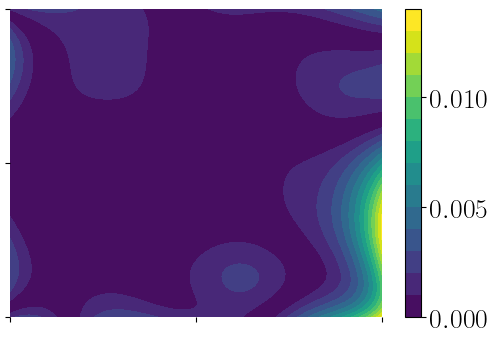

In [96]:
# P forward errors 2 step: P(u_ID) - Phat(u_ID)
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*xy_fine.T, darcy_P_fwd_error_ID_2step,
                levels= 15,
                vmin = vmin,
                vmax = vmax)
# colorbar
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
# save fig
plt.savefig('darcy_P_fwd_error_ID1_2step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            ) 

In [97]:
# vmin and vmax to use same colors
bwd_ID_stacked = jnp.stack([darcy_P_bwd_error_ID_1step,
                            darcy_P_bwd_error_ID_2step])
vmin, vmax = jnp.min(bwd_ID_stacked), jnp.max(bwd_ID_stacked)

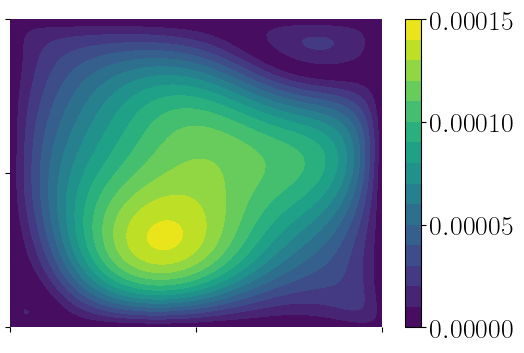

In [98]:
# P backward errors 1 step : u_ID - Phat^1Phat(u_ID)
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*xy_fine.T, darcy_P_bwd_error_ID_1step,
                    levels= 15)
# colorbar
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
# save fig
plt.savefig('darcy_P_bwd_error_ID1_1step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            ) 

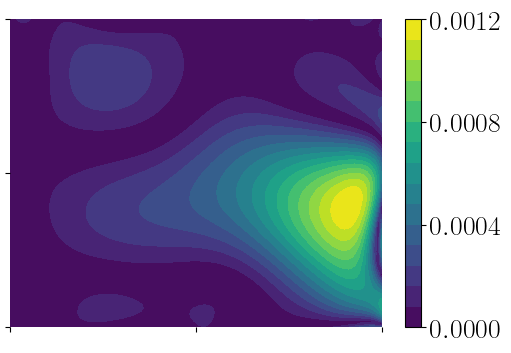

In [99]:
# P backward errors 2 step : u_ID - Phat^1Phat(u_ID)
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*xy_fine.T, darcy_P_bwd_error_ID_2step,
                    levels= 15,
                    vmin = vmin,
                    vmax = vmax)
# colorbar
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
# save fig
plt.savefig('darcy_P_bwd_error_ID1_2step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            ) 

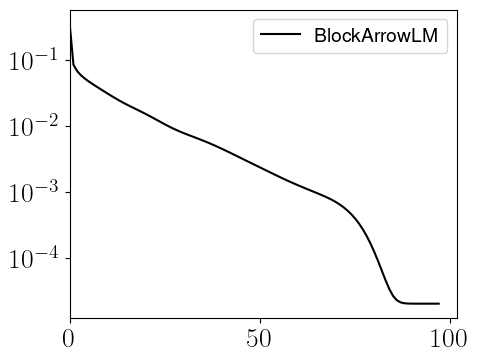

In [100]:
# loss history plot
plt.figure(figsize=(5,4))
plt.plot(range(len(loss_vals_ID_BlockArrowLM)),
         loss_vals_ID_BlockArrowLM,
         color = 'black',
         ls = 'solid',
         label = 'BlockArrowLM'
)

# fig settings
plt.locator_params(axis="x", nbins=3)
plt.locator_params(axis="y", nbins=2)
plt.xlim(left=0)
plt.yscale('log')
plt.legend(loc="upper right",fontsize = 14)
plt.minorticks_off()
#save fig
plt.savefig('darcy_loss_vals_ID1.pdf', 
            bbox_inches='tight',
            format = 'pdf',
            dpi=300)

## errors out-of-distribution (OOD): run = 1

In [101]:
# errors for OD - 1 step
m = 8
obs_pts = 8
run = 1
seed = int(m*obs_pts*(run+1))

# Sample m functions
kernel_GP = get_gaussianRBF(0.5)
xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
u_true_functions = tuple(GP_sampler(num_samples = m,
                                        X = xy_pairs, 
                                        kernel = kernel_GP,
                                        reg = 1e-12,
                                        seed = seed
                                    )
                                    )
# fine grid
xy_fine = jnp.vstack(build_xy_grid([0,1],[0,1],100,100))

# Permeability field A
def A(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

# Compute f = Pu for a given u
def get_rhs_darcy(u):
    def Agradu(xy):
        return A(xy)*jax.grad(u)(xy)
    def Pu(xy):
        return jnp.trace(jax.jacfwd(Agradu)(xy))
    return Pu

# Lists of m true u's and f's
vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed


# Sample collocation points for f using same uniform grid for every function
xy_int_single,xy_bdy_single = build_xy_grid([0,1],[0,1],10,10)
xy_ints = (xy_int_single,)*m
xy_bdys = (xy_bdy_single,)*m


xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

# List of number of observation points per u
num_obs = [obs_pts]*m

# Get (X^m, u^m(X^m))
xy_obs,u_obs = build_u_obs_all(
    num_obs,
    xy_ints,
    xy_bdys,
    vmapped_u_true_functions,
    pkey(seed)
)

# Build operator features
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

# Build interpolants for u's
k_u = get_gaussianRBF(0.5)
u_operators = (eval_k,)

# u_models = tuple([CholInducedRKHS(
#     xy_all[i],
#     u_operators,
#     k_u
#     ) for i in range(m)])

u_model = CholInducedRKHS(xy_all[0],u_operators,k_u)

# Get necessary tuples
observation_points = tuple(xy_obs)
observation_values = tuple(u_obs)
collocation_points = xy_ints


rhs_values = tuple(rhs_func(xy_int) for xy_int,rhs_func in zip(xy_ints,rhs_functions))

all_u_params_init = tuple([
    u_model.get_fitted_params(obs_loc,obs_val,lam = 1e-8)
    for obs_loc,obs_val in zip(observation_points,observation_values)])

grid_features_u_init = jnp.vstack([(
    u_model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for xy_int,model_params in zip(xy_ints,all_u_params_init) ])

grid_features_u_init = jnp.hstack([jnp.vstack(xy_ints),grid_features_u_init])

# P kernel
k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
k_P_x_part = get_gaussianRBF(0.4)

def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
    

# P object        
P_model = InducedOperatorModel(grid_features_u_init,k_P)
num_P_params = len(grid_features_u_init) 

# P, u, f object
collocation_points = xy_ints
EqnModel  = SharedOperatorPDEModel(
    P_model,
    u_model,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 5.,
    num_P_operator_params = 200
)

# OPTIMIZE

u_init = jnp.stack(all_u_params_init)
P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values),lam = 1e-4)

beta_reg = 1e-8

from Optimizers import BlockArrowLM,LMParams
lm_params = LMParams(max_iter = 501,init_alpha = 1e-1,min_alpha = 1e-12,print_every = 100)
u_sol,P_sol,arrow_conv = BlockArrowLM(
    u_init,P_init,EqnModel,beta_reg,beta_reg,
    optParams=lm_params
    )

# loss history
loss_vals_OOD_BlockArrowLM = arrow_conv.loss_vals

# Simulate u true OOD
kernel_GP_OOD = get_gaussianRBF(0.2) # Less regularity as training u's
u_true_OOD = GP_sampler(num_samples = 1,
                X = xy_pairs, 
                kernel = kernel_GP_OOD,
                reg = 1e-12,
                seed = seed
)
# P(u_OOD)(xy_fine)
P_true_OOD = jax.vmap(get_rhs_darcy(u_true_OOD[0]))(xy_fine)
# Phat[S] - 1 step    
P_func = lambda x: P_model.predict(x,P_sol)
# P[\phi(w)](fine_grid)
def evaluate_hatP(P_func, w, fine_grid, feature_operators):
    # Build S_test
    w_features = jnp.array([jax.vmap(operator(w,0))(xy_fine) for operator in feature_operators]).T
    model_fine_features = jnp.hstack([fine_grid, w_features])
    S_test = model_fine_features
    P_preds = P_func(S_test)
    return P_preds
# P_hat(u_OOD)(xy_fine)
P_pred_OOD = evaluate_hatP(P_func, 
                           u_true_OOD[0],
                           xy_fine,
                           feature_operators)

# Collocation points where to solve for \hat P (u) = f_new
num_interior_points = 256
num_grid_points = 20
# Sample collocation points for learning u
xy_interiors,xy_boundarys = sample_multiple_xy_grids_latin(
        num_functions = 1,
        num_interior = num_interior_points,
        x_range = [0,1],
        y_range = [0,1],
        num_grid_x_bdy = num_grid_points,
        num_grid_y_bdy = num_grid_points,
        key = pkey(0)
    )
# Boundary pairs
xy_bdy = xy_boundarys[0]
# Interior pairs (where PDE is satisfied)
xy_int = xy_interiors[0]
# Union of xy_bdy
xy_all = jnp.vstack([xy_int,xy_bdy])

# u_new object
u_model = CholInducedRKHS(
    xy_all,
    feature_operators,
    k_u
    )

def get_u_pde_adj(u_new,f_new):
        
    @jit
    def get_pred_hatP(input_features):
        return P_model.predict(input_features,P_sol)

    

    new_obs = u_new(xy_bdy) # Boundary conditions values that need to be satisfied


    class PdeModel():

        datafit_weight = 50.

        @jit
        def get_grid_features(u_params):
            evaluation = u_model.evaluate_operators(feature_operators,xy_int,u_params)
            grid_features = evaluation.reshape(len(xy_int),len(feature_operators),order = 'F')
            return jnp.hstack([xy_int,grid_features])
        
        @jit
        def get_grid_target(u_params):
            return f_new(xy_int)
        
        @jit
        def eval_obs_points(u_params):
            return u_model.point_evaluate(xy_bdy,u_params)
        
        @jit
        def datafit_residual(u_params):
            obs_preds = PdeModel.eval_obs_points(u_params)
            return new_obs - obs_preds
        
        @jit
        def equation_residual(u_params):
            P_features = PdeModel.get_grid_features(u_params)
            P_model_preds = get_pred_hatP(P_features)
            ugrid_target = PdeModel.get_grid_target(u_params)
            return (ugrid_target - P_model_preds)
        
        @jit
        def F(u_params):
            eqn_res = PdeModel.equation_residual(u_params)
            data_res = PdeModel.datafit_residual(u_params)
            return jnp.hstack([
                PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                eqn_res/jnp.sqrt(len(eqn_res))
                ])
        
        jac = jit(jacrev(F))

        def loss(u_params):
            return jnp.linalg.norm(PdeModel.F(u_params))**2
        
        @jit
        def damping_matrix(u_params):
            return u_model.kmat+1e-5 * diagpart(u_model.kmat)
    
    # Optimize
    new_u_init = jnp.zeros(xy_all.shape[0]*len(feature_operators))

    # Optimizer hyperparameters
    optparams = LMParams(max_iter = 301,
                        line_search_increase_ratio = 1.4,
                        print_every = 100,
                        tol = 1e-10)
    
    u_params_pde, _ = CholeskyLM(
        new_u_init.copy(),
        PdeModel,
        beta = 0,
        optParams = optparams
    )


    return u_params_pde
u_true_func = jax.vmap(u_true_OOD[0])
f_true_func = jax.vmap(get_rhs_darcy(u_true_OOD[0]))
u_pred_ol = u_model.point_evaluate(xy_fine,
                                   get_u_pde_adj(u_true_func,f_true_func)
)
# u_true_OOD vals at fine grid
darcy_u_true_OOD = jax.vmap(u_true_OOD[0])(xy_fine)
# relative error values: P(u_true_OOD) vs. Phat(u_true_OOD)
darcy_P_fwd_error_OOD_1step = jnp.abs(P_true_OOD - P_pred_OOD)/jnp.linalg.norm(P_true_OOD)
# relative error values: u_true_OOD vs. Phat^-1(P(u_true_OOD))
darcy_P_bwd_error_OOD_1step = jnp.abs(darcy_u_true_OOD - u_pred_ol)/jnp.linalg.norm(darcy_u_true_OOD)

  4%|▍         | 19/501 [00:02<00:45, 10.53it/s]

Iteration 0, loss = 0.0833, gradnorm = 2.28, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.0664, gradnorm = 0.06851, alpha = 0.06944, improvement_ratio = 1.001
Iteration 2, loss = 0.05757, gradnorm = 0.03235, alpha = 0.05787, improvement_ratio = 1.001
Iteration 3, loss = 0.05142, gradnorm = 0.02292, alpha = 0.04823, improvement_ratio = 1.001
Iteration 4, loss = 0.04664, gradnorm = 0.0178, alpha = 0.04019, improvement_ratio = 1.001
Iteration 5, loss = 0.04265, gradnorm = 0.01448, alpha = 0.03349, improvement_ratio = 1.001


  3%|▎         | 10/301 [00:24<08:38,  1.78s/it] 

Iteration 0, loss = 1.03e+03, gradnorm = 858.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 909.8, gradnorm = 0.2089, alpha = 2.083, improvement_ratio = 1.0
Iteration 2, loss = 826.4, gradnorm = 0.1501, alpha = 1.736, improvement_ratio = 1.0
Iteration 3, loss = 761.8, gradnorm = 0.1256, alpha = 1.447, improvement_ratio = 1.0
Iteration 4, loss = 708.6, gradnorm = 0.1078, alpha = 1.206, improvement_ratio = 1.0
Iteration 5, loss = 661.8, gradnorm = 0.0948, alpha = 1.005, improvement_ratio = 1.0


 36%|███▌      | 109/301 [00:25<00:04, 42.58it/s]

Iteration 100, loss = 17.3, gradnorm = 0.0005994, alpha = 3.019e-08, improvement_ratio = 1.0


 72%|███████▏  | 217/301 [00:27<00:01, 82.23it/s]

Iteration 200, loss = 8.331, gradnorm = 0.007749, alpha = 8.333e-09, improvement_ratio = 1.001


100%|██████████| 301/301 [00:28<00:00, 10.70it/s]


Iteration 300, loss = 7.567, gradnorm = 0.003952, alpha = 8.333e-09, improvement_ratio = 1.003


In [102]:
# errors for OOD - 2 step
m = 8
obs_pts = 8
run = 1
seed = int(m*obs_pts*(run+1))

# Sample m functions
kernel_GP = get_gaussianRBF(0.5)
xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
u_true_functions = tuple(GP_sampler(num_samples = m,
                                        X = xy_pairs, 
                                        kernel = kernel_GP,
                                        reg = 1e-12,
                                        seed = seed
                                    )
                                    )
# fine grid
xy_fine = jnp.vstack(build_xy_grid([0,1],[0,1],100,100))

# Permeability field A
def A(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

# Compute f = Pu for a given u
def get_rhs_darcy(u):
    def Agradu(xy):
        return A(xy)*jax.grad(u)(xy)
    def Pu(xy):
        return jnp.trace(jax.jacfwd(Agradu)(xy))
    return Pu

# Lists of m true u's and f's
vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed


# Sample collocation points for f using same uniform grid for every function
xy_int_single,xy_bdy_single = build_xy_grid([0,1],[0,1],10,10)
xy_ints = (xy_int_single,)*m
xy_bdys = (xy_bdy_single,)*m


xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

# List of number of observation points per u
num_obs = [obs_pts]*m

# Get (X^m, u^m(X^m))
xy_obs,u_obs = build_u_obs_all(
    num_obs,
    xy_ints,
    xy_bdys,
    vmapped_u_true_functions,
    pkey(seed)
)

# Build operator features
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

# Build interpolants for u's
k_u = get_gaussianRBF(0.5)
u_operators = (eval_k,)

# u_models = tuple([CholInducedRKHS(
#     xy_all[i],
#     u_operators,
#     k_u
#     ) for i in range(m)])

u_model = CholInducedRKHS(xy_all[0],u_operators,k_u)

# Get necessary tuples
observation_points = tuple(xy_obs)
observation_values = tuple(u_obs)
collocation_points = xy_ints


rhs_values = tuple(rhs_func(xy_int) for xy_int,rhs_func in zip(xy_ints,rhs_functions))

all_u_params_init = tuple([
    u_model.get_fitted_params(obs_loc,obs_val,lam = 1e-8)
    for obs_loc,obs_val in zip(observation_points,observation_values)])

grid_features_u_init = jnp.vstack([(
    u_model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for xy_int,model_params in zip(xy_ints,all_u_params_init) ])

grid_features_u_init = jnp.hstack([jnp.vstack(xy_ints),grid_features_u_init])

# P kernel
k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
k_P_x_part = get_gaussianRBF(0.4)

def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
    

# P object        
P_model = InducedOperatorModel(grid_features_u_init,k_P)
num_P_params = len(grid_features_u_init) 

# P, u, f object
collocation_points = xy_ints
EqnModel  = SharedOperatorPDEModel(
    P_model,
    u_model,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 5.,
    num_P_operator_params = 200
)

# u_init = jnp.stack(all_u_params_init)
# P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values),lam = 1e-4)

# beta_reg = 1e-8

# from Optimizers import BlockArrowLM,LMParams
# lm_params = LMParams(max_iter = 501,init_alpha = 1e-1,min_alpha = 1e-12,print_every = 100)
# u_sol,P_sol,arrow_conv = BlockArrowLM(
#     u_init,P_init,EqnModel,beta_reg,beta_reg,
#     optParams=lm_params
#     )

# Simulate u true OOD
kernel_GP_OOD = get_gaussianRBF(0.2) # Less regularity as training u's
u_true_OOD = GP_sampler(num_samples = 1,
                X = xy_pairs, 
                kernel = kernel_GP_OOD,
                reg = 1e-12,
                seed = seed
)
# P(u_OOD)(xy_fine)
P_true_OOD = jax.vmap(get_rhs_darcy(u_true_OOD[0]))(xy_fine)

# Phat[S] - 2 step
init_P_features = jnp.vstack([EqnModel.single_eqn_features(u_params,eval_points) 
                                        for u_params,eval_points in zip(
                                        all_u_params_init,
                                        EqnModel.collocation_points)])
rhs_stacked = EqnModel.stacked_collocation_rhs
P_params_naive = P_model.get_fitted_params(init_P_features,rhs_stacked)
P_func2 = lambda x: P_model.predict(x,P_params_naive)

# P[\phi(w)](fine_grid)
def evaluate_hatP(P_func, w, fine_grid, feature_operators):
    # Build S_test
    w_features = jnp.array([jax.vmap(operator(w,0))(xy_fine) for operator in feature_operators]).T
    model_fine_features = jnp.hstack([fine_grid, w_features])
    S_test = model_fine_features
    P_preds = P_func(S_test)
    return P_preds
# P_hat(u_OOD)(xy_fine)
P_pred_OOD = evaluate_hatP(P_func2, 
                           u_true_OOD[0],
                           xy_fine,
                           feature_operators)

# Collocation points where to solve for \hat P (u) = f_new
num_interior_points = 256
num_grid_points = 20
# Sample collocation points for learning u
xy_interiors,xy_boundarys = sample_multiple_xy_grids_latin(
        num_functions = 1,
        num_interior = num_interior_points,
        x_range = [0,1],
        y_range = [0,1],
        num_grid_x_bdy = num_grid_points,
        num_grid_y_bdy = num_grid_points,
        key = pkey(0)
    )
# Boundary pairs
xy_bdy = xy_boundarys[0]
# Interior pairs (where PDE is satisfied)
xy_int = xy_interiors[0]
# Union of xy_bdy
xy_all = jnp.vstack([xy_int,xy_bdy])

# u_new object
u_model = CholInducedRKHS(
    xy_all,
    feature_operators,
    k_u
    )

def get_u_pde_adj(u_new,f_new):
        
    @jit
    def get_pred_hatP2step(input_features):
        init_P_features = jnp.vstack([EqnModel.single_eqn_features(u_params,eval_points) 
                                                for u_params,eval_points in zip(
                                                all_u_params_init,
                                                EqnModel.collocation_points)])
        rhs_stacked = EqnModel.stacked_collocation_rhs
        P_params_naive = P_model.get_fitted_params(init_P_features,rhs_stacked)
        return P_model.predict(input_features,P_params_naive)

    

    new_obs = u_new(xy_bdy) # Boundary conditions values that need to be satisfied


    class PdeModel():

        datafit_weight = 50.

        @jit
        def get_grid_features(u_params):
            evaluation = u_model.evaluate_operators(feature_operators,xy_int,u_params)
            grid_features = evaluation.reshape(len(xy_int),len(feature_operators),order = 'F')
            return jnp.hstack([xy_int,grid_features])
        
        @jit
        def get_grid_target(u_params):
            return f_new(xy_int)
        
        @jit
        def eval_obs_points(u_params):
            return u_model.point_evaluate(xy_bdy,u_params)
        
        @jit
        def datafit_residual(u_params):
            obs_preds = PdeModel.eval_obs_points(u_params)
            return new_obs - obs_preds
        
        @jit
        def equation_residual(u_params):
            P_features = PdeModel.get_grid_features(u_params)
            P_model_preds = get_pred_hatP2step(P_features)
            ugrid_target = PdeModel.get_grid_target(u_params)
            return (ugrid_target - P_model_preds)
        
        @jit
        def F(u_params):
            eqn_res = PdeModel.equation_residual(u_params)
            data_res = PdeModel.datafit_residual(u_params)
            return jnp.hstack([
                PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                eqn_res/jnp.sqrt(len(eqn_res))
                ])
        
        jac = jit(jacrev(F))

        def loss(u_params):
            return jnp.linalg.norm(PdeModel.F(u_params))**2
        
        @jit
        def damping_matrix(u_params):
            return u_model.kmat+1e-5 * diagpart(u_model.kmat)
    
    # Optimize
    new_u_init = jnp.zeros(xy_all.shape[0]*len(feature_operators))

    # Optimizer hyperparameters
    optparams = LMParams(max_iter = 301,
                        line_search_increase_ratio = 1.4,
                        print_every = 100,
                        tol = 1e-10)
    
    u_params_pde, _ = CholeskyLM(
        new_u_init.copy(),
        PdeModel,
        beta = 0,
        optParams = optparams
    )


    return u_params_pde

u_true_func = jax.vmap(u_true_OOD[0])
f_true_func = jax.vmap(get_rhs_darcy(u_true_OOD[0]))
u_pred_ol = u_model.point_evaluate(xy_fine,
                                   get_u_pde_adj(u_true_func,f_true_func)
)
# u_true_OOD vals at fine grid
darcy_u_true_OOD = jax.vmap(u_true_OOD[0])(xy_fine)
# relative error values: P(u_true_OOD) vs. Phat(u_true_OOD)
darcy_P_fwd_error_OOD_2step = jnp.abs(P_true_OOD - P_pred_OOD)/jnp.linalg.norm(P_true_OOD)
# relative error values: u_true_OOD vs. Phat^-1(P(u_true_OOD))
darcy_P_bwd_error_OOD_2step = jnp.abs(darcy_u_true_OOD - u_pred_ol)/jnp.linalg.norm(darcy_u_true_OOD)

  0%|          | 1/301 [00:25<2:09:41, 25.94s/it]

Iteration 0, loss = 1.47e+03, gradnorm = 834.5, alpha = 2.5, improvement_ratio = 1.0


  1%|          | 2/301 [00:26<54:00, 10.84s/it]  

Iteration 1, loss = 1.318e+03, gradnorm = 0.2259, alpha = 2.083, improvement_ratio = 1.0


  1%|          | 3/301 [00:26<29:50,  6.01s/it]

Iteration 2, loss = 1.212e+03, gradnorm = 0.1638, alpha = 1.736, improvement_ratio = 1.0


  1%|▏         | 4/301 [00:26<18:31,  3.74s/it]

Iteration 3, loss = 1.129e+03, gradnorm = 0.1376, alpha = 1.447, improvement_ratio = 1.0


  2%|▏         | 5/301 [00:26<12:16,  2.49s/it]

Iteration 4, loss = 1.062e+03, gradnorm = 0.1181, alpha = 1.206, improvement_ratio = 1.0


  2%|▏         | 6/301 [00:27<08:30,  1.73s/it]

Iteration 5, loss = 1.005e+03, gradnorm = 0.1033, alpha = 1.005, improvement_ratio = 1.0


 34%|███▎      | 101/301 [00:52<00:52,  3.78it/s]

Iteration 100, loss = 89.18, gradnorm = 0.0006614, alpha = 3.019e-08, improvement_ratio = 1.0


 67%|██████▋   | 201/301 [01:18<00:26,  3.78it/s]

Iteration 200, loss = 67.36, gradnorm = 0.01303, alpha = 8.333e-09, improvement_ratio = 1.003


100%|██████████| 301/301 [01:45<00:00,  2.86it/s]

Iteration 300, loss = 63.29, gradnorm = 0.02662, alpha = 8.333e-09, improvement_ratio = 0.9952


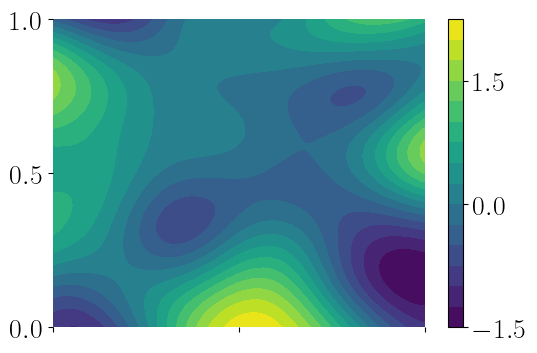

In [103]:
# u_true_OOD plot
plt.figure(figsize=(6,4))
cp=plt.tricontourf(*xy_fine.T, darcy_u_true_OOD,
                levels= 15)
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
plt.gca().set_xticklabels([]) 
# plt.gca().set_yticklabels([])
plt.savefig('darcy_u_true_OOD1.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

In [104]:
# vmin and vmax to use same colors
fwd_OOD_stacked = jnp.stack([darcy_P_fwd_error_OOD_1step,
                            darcy_P_fwd_error_OOD_2step])
vmin, vmax = jnp.min(fwd_OOD_stacked), jnp.max(fwd_OOD_stacked)

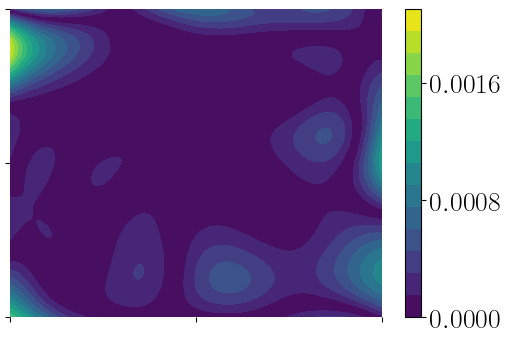

In [105]:
# P forward errors 1 step: P(u_OOD) - Phat(u_OOD)
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*xy_fine.T, darcy_P_fwd_error_OOD_1step,
                    levels= 15)
# colorbar
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
# save fig
plt.savefig('darcy_P_fwd_error_OOD1_1step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            ) 

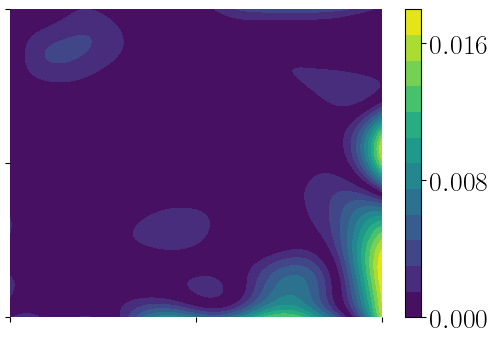

In [106]:
# P forward errors 2 step: P(u_OOD) - Phat(u_OOD)
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*xy_fine.T, darcy_P_fwd_error_OOD_2step,
                    levels= 15)
# colorbar
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
# save fig
plt.savefig('darcy_P_fwd_error_OOD1_2step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            ) 

In [107]:
# vmin and vmax to use same colors
bwd_OOD_stacked = jnp.stack([darcy_P_bwd_error_OOD_1step,
                            darcy_P_bwd_error_OOD_2step])
vmin, vmax = jnp.min(bwd_OOD_stacked), jnp.max(bwd_OOD_stacked)

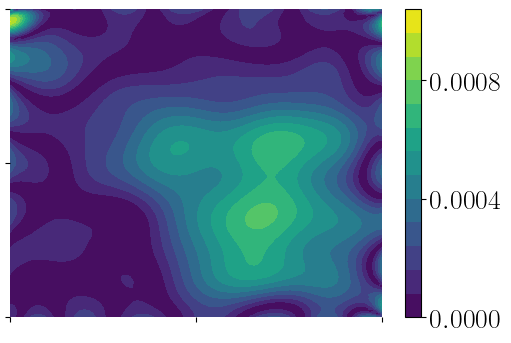

In [108]:
# P backward errors 1 step: u_OOD - Phat^1Phat(u_OOD)
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*xy_fine.T, darcy_P_bwd_error_OOD_1step,
                    levels= 15)
# colorbar
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
# save fig
plt.savefig('darcy_P_bwd_error_OOD1_1step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            ) 

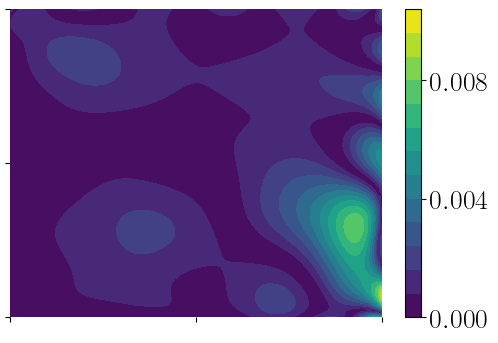

In [109]:
# P backward errors 2 step: u_OOD - Phat^1Phat(u_OOD)
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*xy_fine.T, darcy_P_bwd_error_OOD_2step,
                    levels= 15)
# colorbar
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
# save fig
plt.savefig('darcy_P_bwd_error_OOD1_2step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            ) 

## errors in-distribution(ID): run = 2

In [110]:
# errors for ID - 1 step
m = 8
obs_pts = 8
run = 2
seed = int(m*obs_pts*(run+1))

# Sample m functions
kernel_GP = get_gaussianRBF(0.5)
xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
u_true_functions = tuple(GP_sampler(num_samples = m,
                                        X = xy_pairs, 
                                        kernel = kernel_GP,
                                        reg = 1e-12,
                                        seed = seed
                                    )
                                    )
# fine grid
xy_fine = jnp.vstack(build_xy_grid([0,1],[0,1],100,100))

# Permeability field A
def A(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

# Compute f = Pu for a given u
def get_rhs_darcy(u):
    def Agradu(xy):
        return A(xy)*jax.grad(u)(xy)
    def Pu(xy):
        return jnp.trace(jax.jacfwd(Agradu)(xy))
    return Pu

# Lists of m true u's and f's
vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed


# Sample collocation points for f using same uniform grid for every function
xy_int_single,xy_bdy_single = build_xy_grid([0,1],[0,1],10,10)
xy_ints = (xy_int_single,)*m
xy_bdys = (xy_bdy_single,)*m


xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

# List of number of observation points per u
num_obs = [obs_pts]*m

# Get (X^m, u^m(X^m))
xy_obs,u_obs = build_u_obs_all(
    num_obs,
    xy_ints,
    xy_bdys,
    vmapped_u_true_functions,
    pkey(seed)
)

# Build operator features
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

# Build interpolants for u's
k_u = get_gaussianRBF(0.5)
u_operators = (eval_k,)

# u_models = tuple([CholInducedRKHS(
#     xy_all[i],
#     u_operators,
#     k_u
#     ) for i in range(m)])

u_model = CholInducedRKHS(xy_all[0],u_operators,k_u)

# Get necessary tuples
observation_points = tuple(xy_obs)
observation_values = tuple(u_obs)
collocation_points = xy_ints


rhs_values = tuple(rhs_func(xy_int) for xy_int,rhs_func in zip(xy_ints,rhs_functions))

all_u_params_init = tuple([
    u_model.get_fitted_params(obs_loc,obs_val,lam = 1e-8)
    for obs_loc,obs_val in zip(observation_points,observation_values)])

grid_features_u_init = jnp.vstack([(
    u_model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for xy_int,model_params in zip(xy_ints,all_u_params_init) ])

grid_features_u_init = jnp.hstack([jnp.vstack(xy_ints),grid_features_u_init])

# P kernel
k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
k_P_x_part = get_gaussianRBF(0.4)

def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
    

# P object        
P_model = InducedOperatorModel(grid_features_u_init,k_P)
num_P_params = len(grid_features_u_init) 

# P, u, f object
collocation_points = xy_ints
EqnModel  = SharedOperatorPDEModel(
    P_model,
    u_model,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 5.,
    num_P_operator_params = 200
)

# OPTIMIZE

u_init = jnp.stack(all_u_params_init)
P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values),lam = 1e-4)

beta_reg = 1e-8

from Optimizers import BlockArrowLM,LMParams
lm_params = LMParams(max_iter = 501,init_alpha = 1e-1,min_alpha = 1e-12,print_every = 100)
u_sol,P_sol,arrow_conv = BlockArrowLM(
    u_init,P_init,EqnModel,beta_reg,beta_reg,
    optParams=lm_params
    )

# loss history
loss_vals_ID_BlockArrowLM = arrow_conv.loss_vals


# Simulate u true ID
kernel_GP_ID = get_gaussianRBF(0.5) # Same regularity as training u's
# Sample M training functions from GP(0,K)
u_true_ID = GP_sampler(num_samples = 1,
                X = xy_pairs, 
                kernel = kernel_GP_ID,
                reg = 1e-12,
                seed = seed
)
# P(u_ID)(xy_fine)
P_true_ID = jax.vmap(get_rhs_darcy(u_true_ID[0]))(xy_fine)
# Phat[S] - 1 step    
P_func = lambda x: P_model.predict(x,P_sol)
# P[\phi(w)](fine_grid)
def evaluate_hatP(P_func, w, fine_grid, feature_operators):
    # Build S_test
    w_features = jnp.array([jax.vmap(operator(w,0))(xy_fine) for operator in feature_operators]).T
    model_fine_features = jnp.hstack([fine_grid, w_features])
    S_test = model_fine_features
    P_preds = P_func(S_test)
    return P_preds
# P_hat(u_ID)(xy_fine)
P_pred_ID = evaluate_hatP(P_func, 
                           u_true_ID[0],
                           xy_fine,
                           feature_operators)

# Collocation points where to solve for \hat P (u) = f_new
num_interior_points = 256
num_grid_points = 20
# Sample collocation points for learning u
xy_interiors,xy_boundarys = sample_multiple_xy_grids_latin(
        num_functions = 1,
        num_interior = num_interior_points,
        x_range = [0,1],
        y_range = [0,1],
        num_grid_x_bdy = num_grid_points,
        num_grid_y_bdy = num_grid_points,
        key = pkey(0)
    )
# Boundary pairs
xy_bdy = xy_boundarys[0]
# Interior pairs (where PDE is satisfied)
xy_int = xy_interiors[0]
# Union of xy_bdy
xy_all = jnp.vstack([xy_int,xy_bdy])

# u_new object
u_model = CholInducedRKHS(
    xy_all,
    feature_operators,
    k_u
    )

def get_u_pde_adj(u_new,f_new):
        
    @jit
    def get_pred_hatP(input_features):
        return P_model.predict(input_features,P_sol)

    

    new_obs = u_new(xy_bdy) # Boundary conditions values that need to be satisfied


    class PdeModel():

        datafit_weight = 50.

        @jit
        def get_grid_features(u_params):
            evaluation = u_model.evaluate_operators(feature_operators,xy_int,u_params)
            grid_features = evaluation.reshape(len(xy_int),len(feature_operators),order = 'F')
            return jnp.hstack([xy_int,grid_features])
        
        @jit
        def get_grid_target(u_params):
            return f_new(xy_int)
        
        @jit
        def eval_obs_points(u_params):
            return u_model.point_evaluate(xy_bdy,u_params)
        
        @jit
        def datafit_residual(u_params):
            obs_preds = PdeModel.eval_obs_points(u_params)
            return new_obs - obs_preds
        
        @jit
        def equation_residual(u_params):
            P_features = PdeModel.get_grid_features(u_params)
            P_model_preds = get_pred_hatP(P_features)
            ugrid_target = PdeModel.get_grid_target(u_params)
            return (ugrid_target - P_model_preds)
        
        @jit
        def F(u_params):
            eqn_res = PdeModel.equation_residual(u_params)
            data_res = PdeModel.datafit_residual(u_params)
            return jnp.hstack([
                PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                eqn_res/jnp.sqrt(len(eqn_res))
                ])
        
        jac = jit(jacrev(F))

        def loss(u_params):
            return jnp.linalg.norm(PdeModel.F(u_params))**2
        
        @jit
        def damping_matrix(u_params):
            return u_model.kmat+1e-5 * diagpart(u_model.kmat)
    
    # Optimize
    new_u_init = jnp.zeros(xy_all.shape[0]*len(feature_operators))

    # Optimizer hyperparameters
    optparams = LMParams(max_iter = 301,
                        line_search_increase_ratio = 1.4,
                        print_every = 100,
                        tol = 1e-10)
    
    u_params_pde, _ = CholeskyLM(
        new_u_init.copy(),
        PdeModel,
        beta = 0,
        optParams = optparams
    )


    return u_params_pde
u_true_func = jax.vmap(u_true_ID[0])
f_true_func = jax.vmap(get_rhs_darcy(u_true_ID[0]))
u_pred_ol = u_model.point_evaluate(xy_fine,
                                   get_u_pde_adj(u_true_func,f_true_func)
)
# u_true_ID vals at fine grid
darcy_u_true_ID = jax.vmap(u_true_ID[0])(xy_fine)
# relative error values: P(u_true_ID) vs. Phat(u_true_ID)
darcy_P_fwd_error_ID_1step = jnp.abs(P_true_ID - P_pred_ID)/jnp.linalg.norm(P_true_ID)
# relative error values: u_true_ID vs. Phat^-1(P(u_true_ID))
darcy_P_bwd_error_ID_1step = jnp.abs(darcy_u_true_ID - u_pred_ol)/jnp.linalg.norm(darcy_u_true_ID)

  4%|▍         | 19/501 [00:02<00:46, 10.34it/s]

Iteration 0, loss = 0.03836, gradnorm = 1.123, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.0314, gradnorm = 0.03853, alpha = 0.06944, improvement_ratio = 1.001
Iteration 2, loss = 0.02723, gradnorm = 0.02161, alpha = 0.05787, improvement_ratio = 1.001
Iteration 3, loss = 0.02442, gradnorm = 0.01574, alpha = 0.04823, improvement_ratio = 1.001
Iteration 4, loss = 0.02238, gradnorm = 0.01194, alpha = 0.04019, improvement_ratio = 1.001
Iteration 5, loss = 0.02081, gradnorm = 0.009338, alpha = 0.03349, improvement_ratio = 1.001


  3%|▎         | 10/301 [00:24<08:37,  1.78s/it] 

Iteration 0, loss = 0.001018, gradnorm = 598.0, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 0.0006822, gradnorm = 0.0004392, alpha = 2.083, improvement_ratio = 1.0
Iteration 2, loss = 0.000487, gradnorm = 0.0002, alpha = 1.736, improvement_ratio = 1.0
Iteration 3, loss = 0.0003572, gradnorm = 0.0001489, alpha = 1.447, improvement_ratio = 1.0
Iteration 4, loss = 0.0002713, gradnorm = 0.0001117, alpha = 1.206, improvement_ratio = 1.0
Iteration 5, loss = 0.0002157, gradnorm = 8.34e-05, alpha = 1.005, improvement_ratio = 1.0


 36%|███▌      | 109/301 [00:25<00:04, 42.68it/s]

Iteration 100, loss = 4.529e-06, gradnorm = 2.665e-07, alpha = 3.019e-08, improvement_ratio = 1.0


 72%|███████▏  | 217/301 [00:27<00:01, 82.32it/s]

Iteration 200, loss = 1.84e-06, gradnorm = 1.325e-06, alpha = 8.333e-09, improvement_ratio = 1.007


100%|██████████| 301/301 [00:28<00:00, 10.72it/s]


Iteration 300, loss = 1.775e-06, gradnorm = 1.357e-06, alpha = 8.333e-09, improvement_ratio = 0.9955


In [111]:
# errors for ID - 2 step
m = 8
obs_pts = 8
run = 2
seed = int(m*obs_pts*(run+1))

# Sample m functions
kernel_GP = get_gaussianRBF(0.5)
xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
u_true_functions = tuple(GP_sampler(num_samples = m,
                                        X = xy_pairs, 
                                        kernel = kernel_GP,
                                        reg = 1e-12,
                                        seed = seed
                                    )
                                    )
# fine grid
xy_fine = jnp.vstack(build_xy_grid([0,1],[0,1],100,100))

# Permeability field A
def A(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

# Compute f = Pu for a given u
def get_rhs_darcy(u):
    def Agradu(xy):
        return A(xy)*jax.grad(u)(xy)
    def Pu(xy):
        return jnp.trace(jax.jacfwd(Agradu)(xy))
    return Pu

# Lists of m true u's and f's
vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed


# Sample collocation points for f using same uniform grid for every function
xy_int_single,xy_bdy_single = build_xy_grid([0,1],[0,1],10,10)
xy_ints = (xy_int_single,)*m
xy_bdys = (xy_bdy_single,)*m


xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

# List of number of observation points per u
num_obs = [obs_pts]*m

# Get (X^m, u^m(X^m))
xy_obs,u_obs = build_u_obs_all(
    num_obs,
    xy_ints,
    xy_bdys,
    vmapped_u_true_functions,
    pkey(seed)
)

# Build operator features
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

# Build interpolants for u's
k_u = get_gaussianRBF(0.5)
u_operators = (eval_k,)

# u_models = tuple([CholInducedRKHS(
#     xy_all[i],
#     u_operators,
#     k_u
#     ) for i in range(m)])

u_model = CholInducedRKHS(xy_all[0],u_operators,k_u)

# Get necessary tuples
observation_points = tuple(xy_obs)
observation_values = tuple(u_obs)
collocation_points = xy_ints


rhs_values = tuple(rhs_func(xy_int) for xy_int,rhs_func in zip(xy_ints,rhs_functions))

all_u_params_init = tuple([
    u_model.get_fitted_params(obs_loc,obs_val,lam = 1e-8)
    for obs_loc,obs_val in zip(observation_points,observation_values)])

grid_features_u_init = jnp.vstack([(
    u_model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for xy_int,model_params in zip(xy_ints,all_u_params_init) ])

grid_features_u_init = jnp.hstack([jnp.vstack(xy_ints),grid_features_u_init])

# P kernel
k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
k_P_x_part = get_gaussianRBF(0.4)

def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
    

# P object        
P_model = InducedOperatorModel(grid_features_u_init,k_P)
num_P_params = len(grid_features_u_init) 

# P, u, f object
collocation_points = xy_ints
EqnModel  = SharedOperatorPDEModel(
    P_model,
    u_model,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 5.,
    num_P_operator_params = 200
)

# u_init = jnp.stack(all_u_params_init)
# P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values),lam = 1e-4)

# beta_reg = 1e-8

# from Optimizers import BlockArrowLM,LMParams
# lm_params = LMParams(max_iter = 501,init_alpha = 1e-1,min_alpha = 1e-12,print_every = 100)
# u_sol,P_sol,arrow_conv = BlockArrowLM(
#     u_init,P_init,EqnModel,beta_reg,beta_reg,
#     optParams=lm_params
#     )

# Simulate u true ID
kernel_GP_ID = get_gaussianRBF(0.5) # Same regularity as training u's
# Sample M training functions from GP(0,K)
u_true_ID = GP_sampler(num_samples = 1,
                X = xy_pairs, 
                kernel = kernel_GP_ID,
                reg = 1e-12,
                seed = seed
)
# P(u_ID)(xy_fine)
P_true_ID = jax.vmap(get_rhs_darcy(u_true_ID[0]))(xy_fine)

# Phat[S] - 2 step
init_P_features = jnp.vstack([EqnModel.single_eqn_features(u_params,eval_points) 
                                        for u_params,eval_points in zip(
                                        all_u_params_init,
                                        EqnModel.collocation_points)])
rhs_stacked = EqnModel.stacked_collocation_rhs
P_params_naive = P_model.get_fitted_params(init_P_features,rhs_stacked)
P_func2 = lambda x: P_model.predict(x,P_params_naive)

# P[\phi(w)](fine_grid)
def evaluate_hatP(P_func, w, fine_grid, feature_operators):
    # Build S_test
    w_features = jnp.array([jax.vmap(operator(w,0))(xy_fine) for operator in feature_operators]).T
    model_fine_features = jnp.hstack([fine_grid, w_features])
    S_test = model_fine_features
    P_preds = P_func(S_test)
    return P_preds
# P_hat(u_ID)(xy_fine)
P_pred_ID = evaluate_hatP(P_func2, 
                           u_true_ID[0],
                           xy_fine,
                           feature_operators)

# Collocation points where to solve for \hat P (u) = f_new
num_interior_points = 256
num_grid_points = 20
# Sample collocation points for learning u
xy_interiors,xy_boundarys = sample_multiple_xy_grids_latin(
        num_functions = 1,
        num_interior = num_interior_points,
        x_range = [0,1],
        y_range = [0,1],
        num_grid_x_bdy = num_grid_points,
        num_grid_y_bdy = num_grid_points,
        key = pkey(0)
    )
# Boundary pairs
xy_bdy = xy_boundarys[0]
# Interior pairs (where PDE is satisfied)
xy_int = xy_interiors[0]
# Union of xy_bdy
xy_all = jnp.vstack([xy_int,xy_bdy])

# u_new object
u_model = CholInducedRKHS(
    xy_all,
    feature_operators,
    k_u
    )

def get_u_pde_adj(u_new,f_new):
        
    @jit
    def get_pred_hatP2step(input_features):
        init_P_features = jnp.vstack([EqnModel.single_eqn_features(u_params,eval_points) 
                                                for u_params,eval_points in zip(
                                                all_u_params_init,
                                                EqnModel.collocation_points)])
        rhs_stacked = EqnModel.stacked_collocation_rhs
        P_params_naive = P_model.get_fitted_params(init_P_features,rhs_stacked)
        return P_model.predict(input_features,P_params_naive)

    

    new_obs = u_new(xy_bdy) # Boundary conditions values that need to be satisfied


    class PdeModel():

        datafit_weight = 50.

        @jit
        def get_grid_features(u_params):
            evaluation = u_model.evaluate_operators(feature_operators,xy_int,u_params)
            grid_features = evaluation.reshape(len(xy_int),len(feature_operators),order = 'F')
            return jnp.hstack([xy_int,grid_features])
        
        @jit
        def get_grid_target(u_params):
            return f_new(xy_int)
        
        @jit
        def eval_obs_points(u_params):
            return u_model.point_evaluate(xy_bdy,u_params)
        
        @jit
        def datafit_residual(u_params):
            obs_preds = PdeModel.eval_obs_points(u_params)
            return new_obs - obs_preds
        
        @jit
        def equation_residual(u_params):
            P_features = PdeModel.get_grid_features(u_params)
            P_model_preds = get_pred_hatP2step(P_features)
            ugrid_target = PdeModel.get_grid_target(u_params)
            return (ugrid_target - P_model_preds)
        
        @jit
        def F(u_params):
            eqn_res = PdeModel.equation_residual(u_params)
            data_res = PdeModel.datafit_residual(u_params)
            return jnp.hstack([
                PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                eqn_res/jnp.sqrt(len(eqn_res))
                ])
        
        jac = jit(jacrev(F))

        def loss(u_params):
            return jnp.linalg.norm(PdeModel.F(u_params))**2
        
        @jit
        def damping_matrix(u_params):
            return u_model.kmat+1e-5 * diagpart(u_model.kmat)
    
    # Optimize
    new_u_init = jnp.zeros(xy_all.shape[0]*len(feature_operators))

    # Optimizer hyperparameters
    optparams = LMParams(max_iter = 301,
                        line_search_increase_ratio = 1.4,
                        print_every = 100,
                        tol = 1e-10)
    
    u_params_pde, _ = CholeskyLM(
        new_u_init.copy(),
        PdeModel,
        beta = 0,
        optParams = optparams
    )


    return u_params_pde

u_true_func = jax.vmap(u_true_ID[0])
f_true_func = jax.vmap(get_rhs_darcy(u_true_ID[0]))
u_pred_ol = u_model.point_evaluate(xy_fine,
                                   get_u_pde_adj(u_true_func,f_true_func)
)
# u_true_ID vals at fine grid
darcy_u_true_ID = jax.vmap(u_true_ID[0])(xy_fine)
# relative error values: P(u_true_ID) vs. Phat(u_true_ID)
darcy_P_fwd_error_ID_2step = jnp.abs(P_true_ID - P_pred_ID)/jnp.linalg.norm(P_true_ID)
# relative error values: u_true_ID vs. Phat^-1(P(u_true_ID))
darcy_P_bwd_error_ID_2step = jnp.abs(darcy_u_true_ID - u_pred_ol)/jnp.linalg.norm(darcy_u_true_ID)

  0%|          | 1/301 [00:26<2:11:27, 26.29s/it]

Iteration 0, loss = 0.134, gradnorm = 609.4, alpha = 2.5, improvement_ratio = 1.0


  1%|          | 2/301 [00:26<54:43, 10.98s/it]  

Iteration 1, loss = 0.09041, gradnorm = 0.003993, alpha = 2.083, improvement_ratio = 1.0


  1%|          | 3/301 [00:26<30:13,  6.09s/it]

Iteration 2, loss = 0.07299, gradnorm = 0.002039, alpha = 1.736, improvement_ratio = 1.0


  1%|▏         | 4/301 [00:27<18:44,  3.79s/it]

Iteration 3, loss = 0.06481, gradnorm = 0.001304, alpha = 1.447, improvement_ratio = 1.0


  2%|▏         | 5/301 [00:27<12:24,  2.52s/it]

Iteration 4, loss = 0.06075, gradnorm = 0.0008791, alpha = 1.206, improvement_ratio = 1.0


  2%|▏         | 6/301 [00:27<08:36,  1.75s/it]

Iteration 5, loss = 0.05846, gradnorm = 0.0006343, alpha = 1.005, improvement_ratio = 1.0


 34%|███▎      | 101/301 [00:52<00:52,  3.82it/s]

Iteration 100, loss = 0.003127, gradnorm = 5.294e-06, alpha = 3.019e-08, improvement_ratio = 1.0


 67%|██████▋   | 201/301 [01:18<00:26,  3.82it/s]

Iteration 200, loss = 0.001908, gradnorm = 9.599e-05, alpha = 8.333e-09, improvement_ratio = 0.9979


100%|██████████| 301/301 [01:44<00:00,  2.87it/s]

Iteration 300, loss = 0.001798, gradnorm = 8.949e-05, alpha = 8.333e-09, improvement_ratio = 1.002


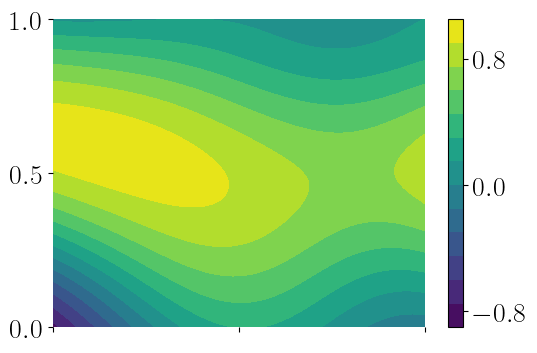

In [112]:
# u_true_ID plot
plt.figure(figsize=(6,4))
cp=plt.tricontourf(*xy_fine.T, darcy_u_true_ID,
                levels= 15)
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
plt.gca().set_xticklabels([]) 
# plt.gca().set_yticklabels([])
plt.savefig('darcy_u_true_ID2.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

In [113]:
# vmin and vmax to use same colors
fwd_ID_stacked = jnp.stack([darcy_P_fwd_error_ID_1step,
                            darcy_P_fwd_error_ID_2step])
vmin, vmax = jnp.min(fwd_ID_stacked), jnp.max(fwd_ID_stacked)

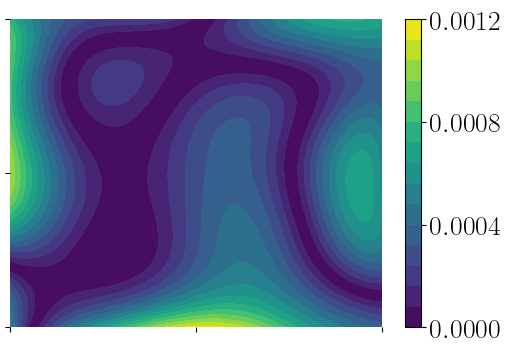

In [114]:
# P forward errors 1 step : P(u_ID) - Phat(u_ID)
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*xy_fine.T, darcy_P_fwd_error_ID_1step,
                levels= 15)
# colorbar
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
# save fig
plt.savefig('darcy_P_fwd_error_ID2_1step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            ) 

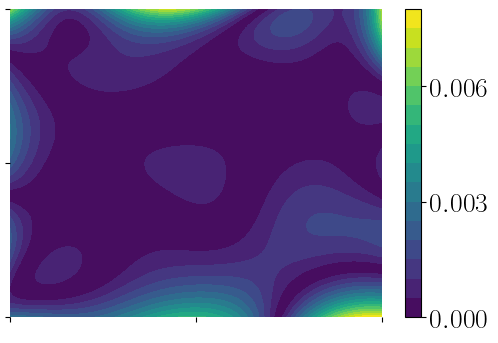

In [115]:
# P forward errors 2 step: P(u_ID) - Phat(u_ID)
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*xy_fine.T, darcy_P_fwd_error_ID_2step,
                levels= 15,
                vmin = vmin,
                vmax = vmax)
# colorbar
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
# save fig
plt.savefig('darcy_P_fwd_error_ID2_2step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            ) 

In [116]:
# vmin and vmax to use same colors
bwd_ID_stacked = jnp.stack([darcy_P_bwd_error_ID_1step,
                            darcy_P_bwd_error_ID_2step])
vmin, vmax = jnp.min(bwd_ID_stacked), jnp.max(bwd_ID_stacked)

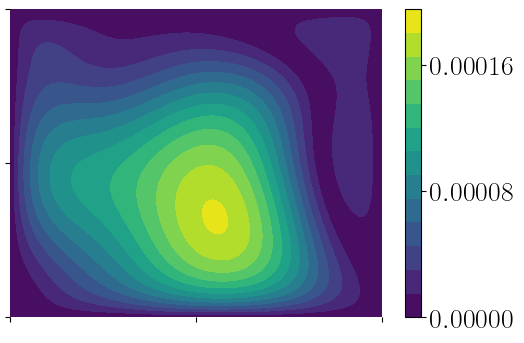

In [117]:
# P backward errors 1 step : u_ID - Phat^1Phat(u_ID)
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*xy_fine.T, darcy_P_bwd_error_ID_1step,
                    levels= 15)
# colorbar
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
# save fig
plt.savefig('darcy_P_bwd_error_ID2_1step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            ) 

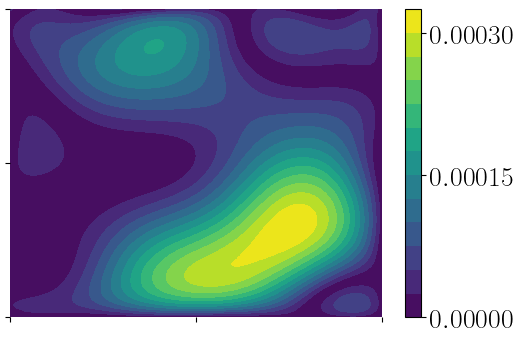

In [118]:
# P backward errors 2 step : u_ID - Phat^1Phat(u_ID)
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*xy_fine.T, darcy_P_bwd_error_ID_2step,
                    levels= 15,
                    vmin = vmin,
                    vmax = vmax)
# colorbar
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
# save fig
plt.savefig('darcy_P_bwd_error_ID2_2step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            ) 

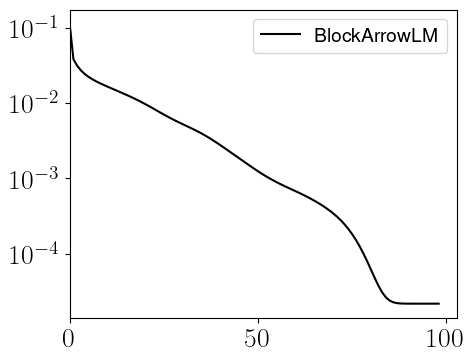

In [119]:
# loss history plot
plt.figure(figsize=(5,4))
plt.plot(range(len(loss_vals_ID_BlockArrowLM)),
         loss_vals_ID_BlockArrowLM,
         color = 'black',
         ls = 'solid',
         label = 'BlockArrowLM'
)

# fig settings
plt.locator_params(axis="x", nbins=3)
plt.locator_params(axis="y", nbins=2)
plt.xlim(left=0)
plt.yscale('log')
plt.legend(loc="upper right",fontsize = 14)
plt.minorticks_off()
#save fig
plt.savefig('darcy_loss_vals_ID2.pdf', 
            bbox_inches='tight',
            format = 'pdf',
            dpi=300)

## errors out-of-distribution (OOD): run = 2

In [120]:
# errors for OD - 1 step
m = 8
obs_pts = 8
run = 2
seed = int(m*obs_pts*(run+1))

# Sample m functions
kernel_GP = get_gaussianRBF(0.5)
xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
u_true_functions = tuple(GP_sampler(num_samples = m,
                                        X = xy_pairs, 
                                        kernel = kernel_GP,
                                        reg = 1e-12,
                                        seed = seed
                                    )
                                    )
# fine grid
xy_fine = jnp.vstack(build_xy_grid([0,1],[0,1],100,100))

# Permeability field A
def A(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

# Compute f = Pu for a given u
def get_rhs_darcy(u):
    def Agradu(xy):
        return A(xy)*jax.grad(u)(xy)
    def Pu(xy):
        return jnp.trace(jax.jacfwd(Agradu)(xy))
    return Pu

# Lists of m true u's and f's
vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed


# Sample collocation points for f using same uniform grid for every function
xy_int_single,xy_bdy_single = build_xy_grid([0,1],[0,1],10,10)
xy_ints = (xy_int_single,)*m
xy_bdys = (xy_bdy_single,)*m


xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

# List of number of observation points per u
num_obs = [obs_pts]*m

# Get (X^m, u^m(X^m))
xy_obs,u_obs = build_u_obs_all(
    num_obs,
    xy_ints,
    xy_bdys,
    vmapped_u_true_functions,
    pkey(seed)
)

# Build operator features
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

# Build interpolants for u's
k_u = get_gaussianRBF(0.5)
u_operators = (eval_k,)

# u_models = tuple([CholInducedRKHS(
#     xy_all[i],
#     u_operators,
#     k_u
#     ) for i in range(m)])

u_model = CholInducedRKHS(xy_all[0],u_operators,k_u)

# Get necessary tuples
observation_points = tuple(xy_obs)
observation_values = tuple(u_obs)
collocation_points = xy_ints


rhs_values = tuple(rhs_func(xy_int) for xy_int,rhs_func in zip(xy_ints,rhs_functions))

all_u_params_init = tuple([
    u_model.get_fitted_params(obs_loc,obs_val,lam = 1e-8)
    for obs_loc,obs_val in zip(observation_points,observation_values)])

grid_features_u_init = jnp.vstack([(
    u_model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for xy_int,model_params in zip(xy_ints,all_u_params_init) ])

grid_features_u_init = jnp.hstack([jnp.vstack(xy_ints),grid_features_u_init])

# P kernel
k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
k_P_x_part = get_gaussianRBF(0.4)

def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
    

# P object        
P_model = InducedOperatorModel(grid_features_u_init,k_P)
num_P_params = len(grid_features_u_init) 

# P, u, f object
collocation_points = xy_ints
EqnModel  = SharedOperatorPDEModel(
    P_model,
    u_model,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 5.,
    num_P_operator_params = 200
)

# OPTIMIZE

u_init = jnp.stack(all_u_params_init)
P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values),lam = 1e-4)

beta_reg = 1e-8

from Optimizers import BlockArrowLM,LMParams
lm_params = LMParams(max_iter = 501,init_alpha = 1e-1,min_alpha = 1e-12,print_every = 100)
u_sol,P_sol,arrow_conv = BlockArrowLM(
    u_init,P_init,EqnModel,beta_reg,beta_reg,
    optParams=lm_params
    )

# loss history
loss_vals_OOD_BlockArrowLM = arrow_conv.loss_vals

# Simulate u true OOD
kernel_GP_OOD = get_gaussianRBF(0.2) # Less regularity as training u's
u_true_OOD = GP_sampler(num_samples = 1,
                X = xy_pairs, 
                kernel = kernel_GP_OOD,
                reg = 1e-12,
                seed = seed
)
# P(u_OOD)(xy_fine)
P_true_OOD = jax.vmap(get_rhs_darcy(u_true_OOD[0]))(xy_fine)
# Phat[S] - 1 step    
P_func = lambda x: P_model.predict(x,P_sol)
# P[\phi(w)](fine_grid)
def evaluate_hatP(P_func, w, fine_grid, feature_operators):
    # Build S_test
    w_features = jnp.array([jax.vmap(operator(w,0))(xy_fine) for operator in feature_operators]).T
    model_fine_features = jnp.hstack([fine_grid, w_features])
    S_test = model_fine_features
    P_preds = P_func(S_test)
    return P_preds
# P_hat(u_OOD)(xy_fine)
P_pred_OOD = evaluate_hatP(P_func, 
                           u_true_OOD[0],
                           xy_fine,
                           feature_operators)

# Collocation points where to solve for \hat P (u) = f_new
num_interior_points = 256
num_grid_points = 20
# Sample collocation points for learning u
xy_interiors,xy_boundarys = sample_multiple_xy_grids_latin(
        num_functions = 1,
        num_interior = num_interior_points,
        x_range = [0,1],
        y_range = [0,1],
        num_grid_x_bdy = num_grid_points,
        num_grid_y_bdy = num_grid_points,
        key = pkey(0)
    )
# Boundary pairs
xy_bdy = xy_boundarys[0]
# Interior pairs (where PDE is satisfied)
xy_int = xy_interiors[0]
# Union of xy_bdy
xy_all = jnp.vstack([xy_int,xy_bdy])

# u_new object
u_model = CholInducedRKHS(
    xy_all,
    feature_operators,
    k_u
    )

def get_u_pde_adj(u_new,f_new):
        
    @jit
    def get_pred_hatP(input_features):
        return P_model.predict(input_features,P_sol)

    

    new_obs = u_new(xy_bdy) # Boundary conditions values that need to be satisfied


    class PdeModel():

        datafit_weight = 50.

        @jit
        def get_grid_features(u_params):
            evaluation = u_model.evaluate_operators(feature_operators,xy_int,u_params)
            grid_features = evaluation.reshape(len(xy_int),len(feature_operators),order = 'F')
            return jnp.hstack([xy_int,grid_features])
        
        @jit
        def get_grid_target(u_params):
            return f_new(xy_int)
        
        @jit
        def eval_obs_points(u_params):
            return u_model.point_evaluate(xy_bdy,u_params)
        
        @jit
        def datafit_residual(u_params):
            obs_preds = PdeModel.eval_obs_points(u_params)
            return new_obs - obs_preds
        
        @jit
        def equation_residual(u_params):
            P_features = PdeModel.get_grid_features(u_params)
            P_model_preds = get_pred_hatP(P_features)
            ugrid_target = PdeModel.get_grid_target(u_params)
            return (ugrid_target - P_model_preds)
        
        @jit
        def F(u_params):
            eqn_res = PdeModel.equation_residual(u_params)
            data_res = PdeModel.datafit_residual(u_params)
            return jnp.hstack([
                PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                eqn_res/jnp.sqrt(len(eqn_res))
                ])
        
        jac = jit(jacrev(F))

        def loss(u_params):
            return jnp.linalg.norm(PdeModel.F(u_params))**2
        
        @jit
        def damping_matrix(u_params):
            return u_model.kmat+1e-5 * diagpart(u_model.kmat)
    
    # Optimize
    new_u_init = jnp.zeros(xy_all.shape[0]*len(feature_operators))

    # Optimizer hyperparameters
    optparams = LMParams(max_iter = 301,
                        line_search_increase_ratio = 1.4,
                        print_every = 100,
                        tol = 1e-10)
    
    u_params_pde, _ = CholeskyLM(
        new_u_init.copy(),
        PdeModel,
        beta = 0,
        optParams = optparams
    )


    return u_params_pde
u_true_func = jax.vmap(u_true_OOD[0])
f_true_func = jax.vmap(get_rhs_darcy(u_true_OOD[0]))
u_pred_ol = u_model.point_evaluate(xy_fine,
                                   get_u_pde_adj(u_true_func,f_true_func)
)
# u_true_OOD vals at fine grid
darcy_u_true_OOD = jax.vmap(u_true_OOD[0])(xy_fine)
# relative error values: P(u_true_OOD) vs. Phat(u_true_OOD)
darcy_P_fwd_error_OOD_1step = jnp.abs(P_true_OOD - P_pred_OOD)/jnp.linalg.norm(P_true_OOD)
# relative error values: u_true_OOD vs. Phat^-1(P(u_true_OOD))
darcy_P_bwd_error_OOD_1step = jnp.abs(darcy_u_true_OOD - u_pred_ol)/jnp.linalg.norm(darcy_u_true_OOD)

  4%|▍         | 20/501 [00:02<00:43, 10.98it/s]

Iteration 0, loss = 0.03836, gradnorm = 1.123, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.0314, gradnorm = 0.03853, alpha = 0.06944, improvement_ratio = 1.001
Iteration 2, loss = 0.02723, gradnorm = 0.02161, alpha = 0.05787, improvement_ratio = 1.001
Iteration 3, loss = 0.02442, gradnorm = 0.01574, alpha = 0.04823, improvement_ratio = 1.001
Iteration 4, loss = 0.02238, gradnorm = 0.01194, alpha = 0.04019, improvement_ratio = 1.001
Iteration 5, loss = 0.02081, gradnorm = 0.009338, alpha = 0.03349, improvement_ratio = 1.001


  3%|▎         | 10/301 [00:24<08:33,  1.76s/it] 

Iteration 0, loss = 991.8, gradnorm = 1.788e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 850.9, gradnorm = 0.2102, alpha = 2.083, improvement_ratio = 1.0
Iteration 2, loss = 766.3, gradnorm = 0.1443, alpha = 1.736, improvement_ratio = 1.0
Iteration 3, loss = 712.6, gradnorm = 0.1097, alpha = 1.447, improvement_ratio = 1.0
Iteration 4, loss = 677.2, gradnorm = 0.08576, alpha = 1.206, improvement_ratio = 1.0
Iteration 5, loss = 651.4, gradnorm = 0.0701, alpha = 1.005, improvement_ratio = 1.0


 36%|███▌      | 109/301 [00:25<00:04, 42.84it/s]

Iteration 100, loss = 16.82, gradnorm = 0.0004844, alpha = 3.019e-08, improvement_ratio = 1.0


 72%|███████▏  | 217/301 [00:26<00:01, 82.13it/s]

Iteration 200, loss = 11.13, gradnorm = 0.003289, alpha = 8.333e-09, improvement_ratio = 0.9997


100%|██████████| 301/301 [00:27<00:00, 10.79it/s]


Iteration 300, loss = 10.2, gradnorm = 0.007402, alpha = 8.333e-09, improvement_ratio = 1.001


In [121]:
# errors for OOD - 2 step
m = 8
obs_pts = 8
run = 2
seed = int(m*obs_pts*(run+1))

# Sample m functions
kernel_GP = get_gaussianRBF(0.5)
xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
u_true_functions = tuple(GP_sampler(num_samples = m,
                                        X = xy_pairs, 
                                        kernel = kernel_GP,
                                        reg = 1e-12,
                                        seed = seed
                                    )
                                    )
# fine grid
xy_fine = jnp.vstack(build_xy_grid([0,1],[0,1],100,100))

# Permeability field A
def A(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

# Compute f = Pu for a given u
def get_rhs_darcy(u):
    def Agradu(xy):
        return A(xy)*jax.grad(u)(xy)
    def Pu(xy):
        return jnp.trace(jax.jacfwd(Agradu)(xy))
    return Pu

# Lists of m true u's and f's
vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed


# Sample collocation points for f using same uniform grid for every function
xy_int_single,xy_bdy_single = build_xy_grid([0,1],[0,1],10,10)
xy_ints = (xy_int_single,)*m
xy_bdys = (xy_bdy_single,)*m


xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

# List of number of observation points per u
num_obs = [obs_pts]*m

# Get (X^m, u^m(X^m))
xy_obs,u_obs = build_u_obs_all(
    num_obs,
    xy_ints,
    xy_bdys,
    vmapped_u_true_functions,
    pkey(seed)
)

# Build operator features
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

# Build interpolants for u's
k_u = get_gaussianRBF(0.5)
u_operators = (eval_k,)

# u_models = tuple([CholInducedRKHS(
#     xy_all[i],
#     u_operators,
#     k_u
#     ) for i in range(m)])

u_model = CholInducedRKHS(xy_all[0],u_operators,k_u)

# Get necessary tuples
observation_points = tuple(xy_obs)
observation_values = tuple(u_obs)
collocation_points = xy_ints


rhs_values = tuple(rhs_func(xy_int) for xy_int,rhs_func in zip(xy_ints,rhs_functions))

all_u_params_init = tuple([
    u_model.get_fitted_params(obs_loc,obs_val,lam = 1e-8)
    for obs_loc,obs_val in zip(observation_points,observation_values)])

grid_features_u_init = jnp.vstack([(
    u_model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for xy_int,model_params in zip(xy_ints,all_u_params_init) ])

grid_features_u_init = jnp.hstack([jnp.vstack(xy_ints),grid_features_u_init])

# P kernel
k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
k_P_x_part = get_gaussianRBF(0.4)

def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
    

# P object        
P_model = InducedOperatorModel(grid_features_u_init,k_P)
num_P_params = len(grid_features_u_init) 

# P, u, f object
collocation_points = xy_ints
EqnModel  = SharedOperatorPDEModel(
    P_model,
    u_model,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 5.,
    num_P_operator_params = 200
)

# u_init = jnp.stack(all_u_params_init)
# P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values),lam = 1e-4)

# beta_reg = 1e-8

# from Optimizers import BlockArrowLM,LMParams
# lm_params = LMParams(max_iter = 501,init_alpha = 1e-1,min_alpha = 1e-12,print_every = 100)
# u_sol,P_sol,arrow_conv = BlockArrowLM(
#     u_init,P_init,EqnModel,beta_reg,beta_reg,
#     optParams=lm_params
#     )

# Simulate u true OOD
kernel_GP_OOD = get_gaussianRBF(0.2) # Less regularity as training u's
u_true_OOD = GP_sampler(num_samples = 1,
                X = xy_pairs, 
                kernel = kernel_GP_OOD,
                reg = 1e-12,
                seed = seed
)
# P(u_OOD)(xy_fine)
P_true_OOD = jax.vmap(get_rhs_darcy(u_true_OOD[0]))(xy_fine)

# Phat[S] - 2 step
init_P_features = jnp.vstack([EqnModel.single_eqn_features(u_params,eval_points) 
                                        for u_params,eval_points in zip(
                                        all_u_params_init,
                                        EqnModel.collocation_points)])
rhs_stacked = EqnModel.stacked_collocation_rhs
P_params_naive = P_model.get_fitted_params(init_P_features,rhs_stacked)
P_func2 = lambda x: P_model.predict(x,P_params_naive)

# P[\phi(w)](fine_grid)
def evaluate_hatP(P_func, w, fine_grid, feature_operators):
    # Build S_test
    w_features = jnp.array([jax.vmap(operator(w,0))(xy_fine) for operator in feature_operators]).T
    model_fine_features = jnp.hstack([fine_grid, w_features])
    S_test = model_fine_features
    P_preds = P_func(S_test)
    return P_preds
# P_hat(u_OOD)(xy_fine)
P_pred_OOD = evaluate_hatP(P_func2, 
                           u_true_OOD[0],
                           xy_fine,
                           feature_operators)

# Collocation points where to solve for \hat P (u) = f_new
num_interior_points = 256
num_grid_points = 20
# Sample collocation points for learning u
xy_interiors,xy_boundarys = sample_multiple_xy_grids_latin(
        num_functions = 1,
        num_interior = num_interior_points,
        x_range = [0,1],
        y_range = [0,1],
        num_grid_x_bdy = num_grid_points,
        num_grid_y_bdy = num_grid_points,
        key = pkey(0)
    )
# Boundary pairs
xy_bdy = xy_boundarys[0]
# Interior pairs (where PDE is satisfied)
xy_int = xy_interiors[0]
# Union of xy_bdy
xy_all = jnp.vstack([xy_int,xy_bdy])

# u_new object
u_model = CholInducedRKHS(
    xy_all,
    feature_operators,
    k_u
    )

def get_u_pde_adj(u_new,f_new):
        
    @jit
    def get_pred_hatP2step(input_features):
        init_P_features = jnp.vstack([EqnModel.single_eqn_features(u_params,eval_points) 
                                                for u_params,eval_points in zip(
                                                all_u_params_init,
                                                EqnModel.collocation_points)])
        rhs_stacked = EqnModel.stacked_collocation_rhs
        P_params_naive = P_model.get_fitted_params(init_P_features,rhs_stacked)
        return P_model.predict(input_features,P_params_naive)

    

    new_obs = u_new(xy_bdy) # Boundary conditions values that need to be satisfied


    class PdeModel():

        datafit_weight = 50.

        @jit
        def get_grid_features(u_params):
            evaluation = u_model.evaluate_operators(feature_operators,xy_int,u_params)
            grid_features = evaluation.reshape(len(xy_int),len(feature_operators),order = 'F')
            return jnp.hstack([xy_int,grid_features])
        
        @jit
        def get_grid_target(u_params):
            return f_new(xy_int)
        
        @jit
        def eval_obs_points(u_params):
            return u_model.point_evaluate(xy_bdy,u_params)
        
        @jit
        def datafit_residual(u_params):
            obs_preds = PdeModel.eval_obs_points(u_params)
            return new_obs - obs_preds
        
        @jit
        def equation_residual(u_params):
            P_features = PdeModel.get_grid_features(u_params)
            P_model_preds = get_pred_hatP2step(P_features)
            ugrid_target = PdeModel.get_grid_target(u_params)
            return (ugrid_target - P_model_preds)
        
        @jit
        def F(u_params):
            eqn_res = PdeModel.equation_residual(u_params)
            data_res = PdeModel.datafit_residual(u_params)
            return jnp.hstack([
                PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                eqn_res/jnp.sqrt(len(eqn_res))
                ])
        
        jac = jit(jacrev(F))

        def loss(u_params):
            return jnp.linalg.norm(PdeModel.F(u_params))**2
        
        @jit
        def damping_matrix(u_params):
            return u_model.kmat+1e-5 * diagpart(u_model.kmat)
    
    # Optimize
    new_u_init = jnp.zeros(xy_all.shape[0]*len(feature_operators))

    # Optimizer hyperparameters
    optparams = LMParams(max_iter = 301,
                        line_search_increase_ratio = 1.4,
                        print_every = 100,
                        tol = 1e-10)
    
    u_params_pde, _ = CholeskyLM(
        new_u_init.copy(),
        PdeModel,
        beta = 0,
        optParams = optparams
    )


    return u_params_pde

u_true_func = jax.vmap(u_true_OOD[0])
f_true_func = jax.vmap(get_rhs_darcy(u_true_OOD[0]))
u_pred_ol = u_model.point_evaluate(xy_fine,
                                   get_u_pde_adj(u_true_func,f_true_func)
)
# u_true_OOD vals at fine grid
darcy_u_true_OOD = jax.vmap(u_true_OOD[0])(xy_fine)
# relative error values: P(u_true_OOD) vs. Phat(u_true_OOD)
darcy_P_fwd_error_OOD_2step = jnp.abs(P_true_OOD - P_pred_OOD)/jnp.linalg.norm(P_true_OOD)
# relative error values: u_true_OOD vs. Phat^-1(P(u_true_OOD))
darcy_P_bwd_error_OOD_2step = jnp.abs(darcy_u_true_OOD - u_pred_ol)/jnp.linalg.norm(darcy_u_true_OOD)

  0%|          | 1/301 [00:26<2:14:26, 26.89s/it]

Iteration 0, loss = 974.0, gradnorm = 1.767e+03, alpha = 2.5, improvement_ratio = 1.0


  1%|          | 2/301 [00:27<55:56, 11.23s/it]  

Iteration 1, loss = 853.1, gradnorm = 0.197, alpha = 2.083, improvement_ratio = 1.0


  1%|          | 3/301 [00:27<30:53,  6.22s/it]

Iteration 2, loss = 777.8, gradnorm = 0.1363, alpha = 1.736, improvement_ratio = 1.0


  1%|▏         | 4/301 [00:27<19:08,  3.87s/it]

Iteration 3, loss = 726.3, gradnorm = 0.1074, alpha = 1.447, improvement_ratio = 1.0


  2%|▏         | 5/301 [00:27<12:39,  2.57s/it]

Iteration 4, loss = 688.1, gradnorm = 0.08832, alpha = 1.206, improvement_ratio = 1.0


  2%|▏         | 6/301 [00:28<08:46,  1.78s/it]

Iteration 5, loss = 657.2, gradnorm = 0.07564, alpha = 1.005, improvement_ratio = 1.0


 34%|███▎      | 101/301 [00:53<00:52,  3.82it/s]

Iteration 100, loss = 19.89, gradnorm = 0.0009341, alpha = 3.019e-08, improvement_ratio = 1.0


 67%|██████▋   | 201/301 [01:19<00:26,  3.83it/s]

Iteration 200, loss = 14.13, gradnorm = 0.002194, alpha = 8.333e-09, improvement_ratio = 0.9982


100%|██████████| 301/301 [01:45<00:00,  2.85it/s]

Iteration 300, loss = 12.74, gradnorm = 0.004879, alpha = 8.333e-09, improvement_ratio = 0.999


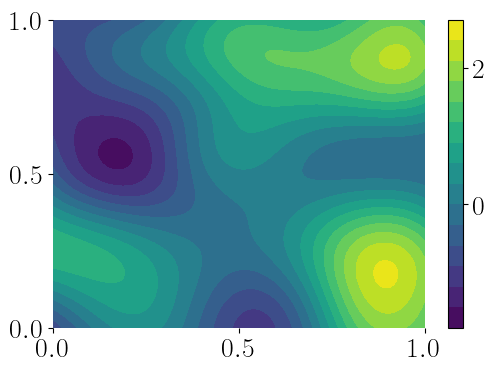

In [122]:
# u_true_OOD plot
plt.figure(figsize=(6,4))
cp=plt.tricontourf(*xy_fine.T, darcy_u_true_OOD,
                levels= 15)
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
# plt.gca().set_xticklabels([]) 
# plt.gca().set_yticklabels([])
plt.savefig('darcy_u_true_OOD2.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

In [123]:
# vmin and vmax to use same colors
fwd_OOD_stacked = jnp.stack([darcy_P_fwd_error_OOD_1step,
                            darcy_P_fwd_error_OOD_2step])
vmin, vmax = jnp.min(fwd_OOD_stacked), jnp.max(fwd_OOD_stacked)

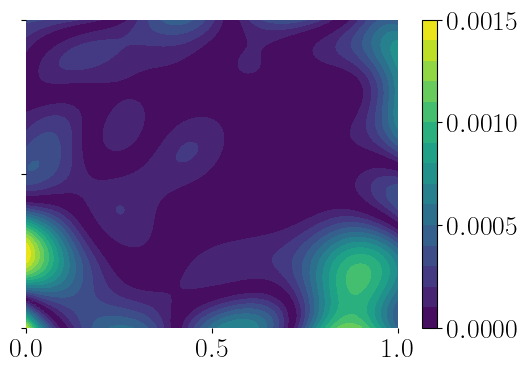

In [124]:
# P forward errors 1 step: P(u_OOD) - Phat(u_OOD)
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*xy_fine.T, darcy_P_fwd_error_OOD_1step,
                    levels= 15)
# colorbar
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_yticklabels([])
# plt.gca().set_xticklabels([])
# save fig
plt.savefig('darcy_P_fwd_error_OOD2_1step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            ) 

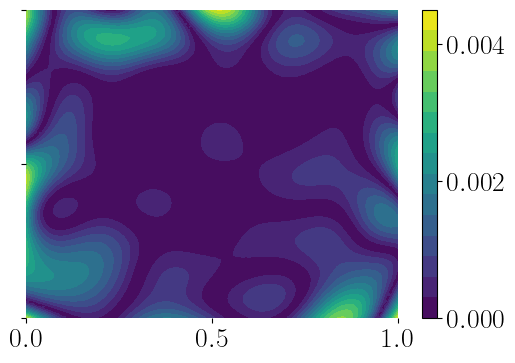

In [125]:
# P forward errors 2 step: P(u_OOD) - Phat(u_OOD)
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*xy_fine.T, darcy_P_fwd_error_OOD_2step,
                    levels= 15)
# colorbar
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_yticklabels([])
# plt.gca().set_xticklabels([])
# save fig
plt.savefig('darcy_P_fwd_error_OOD2_2step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            ) 

In [126]:
# vmin and vmax to use same colors
bwd_OOD_stacked = jnp.stack([darcy_P_bwd_error_OOD_1step,
                            darcy_P_bwd_error_OOD_2step])
vmin, vmax = jnp.min(bwd_OOD_stacked), jnp.max(bwd_OOD_stacked)

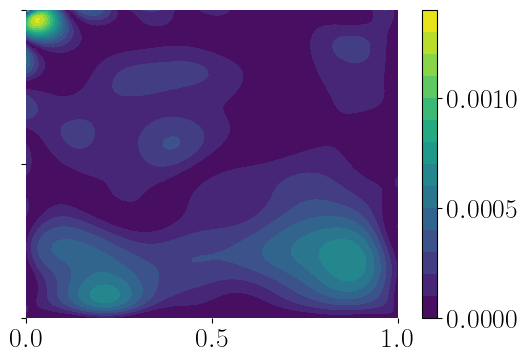

In [127]:
# P backward errors 1 step: u_OOD - Phat^1Phat(u_OOD)
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*xy_fine.T, darcy_P_bwd_error_OOD_1step,
                    levels= 15)
# colorbar
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_yticklabels([])
# plt.gca().set_xticklabels([])
# save fig
plt.savefig('darcy_P_bwd_error_OOD2_1step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            ) 

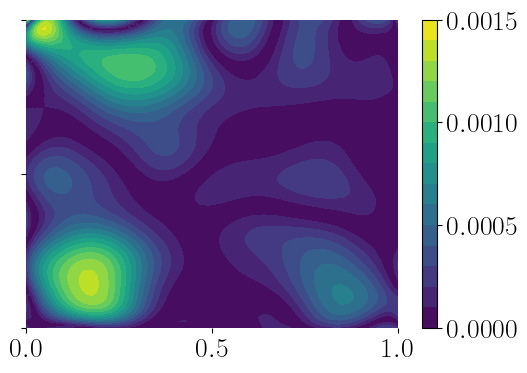

In [128]:
# P backward errors 2 step: u_OOD - Phat^1Phat(u_OOD)
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*xy_fine.T, darcy_P_bwd_error_OOD_2step,
                    levels= 15)
# colorbar
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_yticklabels([])
# plt.gca().set_xticklabels([])
# save fig
plt.savefig('darcy_P_bwd_error_OOD2_2step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            ) 